# Présentation du notebook

## Objectifs


Ce notebook est destiné à explorer la pertinence des **features "non localisés"** utilisés pour la classification des défauts dans les images thermographiques de modules photovoltaïques.

Pour rappel, les images thermographiques dont nous disposons sont des images en 256 niveaux de gris (en effet, la représentation en couleurs de ces images résulte seulement de l'application d'une palette RGB de type 'inferno' permettant une meilleure différenciation des niveaux de température pour l'oeil humain). **Nous ne maîtrisons pas et n'avons aucune information** sur la chaîne de pré-traitement ayant permis la conversion en niveaux de gris des valeurs de température mesurées par les caméras thermiques.

**Les features "non localisés" comprennent** :

  - les **indicateurs statistiques classiques**, du type moyenne, médiane, min, max, etc. calculés sur l'ensemble des pixels de l'image
  - les **quantiles** p5, p10, p15... à p95
  - l'**histogramme de l'image**, pour chaque niveau de 0 à 255
  - les caractéristiques extraites de la **matrice GLCM** (Gray-Level Co-occurence Matrix) calculée sur l'image
  - les indicateurs statistiques calculés sur la **carte d'entropie**, qui caractérise la complexité locale de l'image
  - la **densité de contours**, obtenus à l'aide d'un **filtre de Canny**
  - des caractéristiques statistiques liées aux **"hot spots"** repérés dans les images à l'aide d'un **seuillage OTSU**

La raison pour laquelle il a été décidé de se focaliser sur des features "non localisés" est une **raison "métier"**, liée à la **physique des défaillances** des modules photovoltaïques : la plupart des classes de défauts à notre disposition sont liées à des défaillances qui peuvent se produire à n'importe quel endroit d'un module photovoltaïque. Les seules exceptions (dans notre jeu de données) sont "junction box", que l'on retrouve nécessairement au niveau de la position des boîtes de jonction placées en face arrière, et "bottom dirt", dû à l'accumulation de salissures en bas de module par l'effet de la gravité combiné à d'éventuelles précipitations.

## Utilisation

Ce notebook est essentiellement un **notebook de travail**. Il présente les outils (classes, fonctions) et la méthode utilisée pour explorer les performances de différents modèles de Machine Learning sur notre jeu de données, selon les hypothèses présentées dans la section précédente.

Il est néanmoins possible de l'exécuter de bout en bout en cliquant sur le bouton `Run All Cells` de l'environnement Jupyter. \
Dans ce cas :
- La recherche des meilleurs paramètres se fait sur une **grille de recherche réduite**, afin de minimiser le temps d'exécution (mais on peut tout de même en voir les résultats, ce qui permet de comprendre comment utiliser le notebook).
  - Les grilles de recherche utilisées au cours du travail d'exploration sont commentées et peuvent être réactivées au besoin.
- La partie _log des runs vers MLflow_ est ignorée.
  - La variable globale `ACTIVATE_MLFLOW` (section [Configuration](#Configuration) ci-après) est utilisée pour activer ou désactiver les fonctions de log vers un serveur MLflow.
- Le meilleur pipeline trouvé pour chacun des principaux classifieurs évalués est utilisé pour afficher les résultats finaux (section [Meilleur pipeline par classifieur](#Meilleur-pipeline-par-classifieur)).
- La partie interprétabilité se focalise sur les 2 pipelines présentant les meilleurs résultats : XGBoost et LightGBM.

## Methodologie

Cette section décrit la méthodologie de recherche utilisée dans ce notebook pour déterminer les meilleurs paramètres de pipelines pour les différents classifieurs évalués.

**Remarques préalables** :
- Pour la plupart des grilles de recherche, on garde les 2 options de sampler : `[albumentations_oversampler]` et `[passthrough]`, sous la forme de 2 options séparées. Cela permet d'exécuter un GridSearch différent pour chaque option et ainsi d'obtenir 2 'best_estimator' : un avec l'augmentation de données, l'autre sans. L'idée était de bien mettre en évidence le gain (ou l'absence de gain) apporté par l'approche d'augmentation de données choisie.
- La recherche du meilleur pipeline se fait **classifieur par classifieur**. C'est-à-dire qu'on va d'abord rechercher le meilleur pipeline basé sur RandomForest, puis sur SVC, puis XGBoost, etc.
- En termes de métriques, on regarde évidemment l'**accuracy**, mais aussi le score **f1_macro** (pas le f1_weighted car nos classes sont déséquilibrées et nous avons choisi de considérer qu'elles ont la même importance), ainsi que le la **précision** et le **rappel** sur les classes **healthy** (ce qui permet d'avoir une évaluation de la performance du classifieur sur la différenciation entre modules sains et défectueux en général), **break**, **debris cover** et **string short circuit** (qui sont nos classes minoritaires et les plus difficiles à détecter).

1. **Etape 1 - optimisation extracteurs + scalers**

    - Paramètres par défaut du classifieur en cours
    - Extracteurs : pour chaque extracteur sauf `BaseStatsExtractor`, on propose l'option `drop` dans la grille de paramètres : 2^5, soit 32 combinaisons
    - Scalers : les 3 scalers possibles sont proposés : 3 combinaisons
      - Attention : a priori, l'application d'un scaling est inutile pour les classifieurs basés sur des arbres de décision comme DecisionTree, RandomForest, XGBoost, LightGBM, ...
    
    Au total, cela fait donc 2 x 96 combinaisons à évaluer pour l'étape 1.

    **=> A l'issue de cette étape, on peut fixer les extracteurs et le scaler à retenir.**

2. **Etape 2 - Optimisation de la réduction de dimensions / sélection de features**

    - Paramètres par défaut du classifieur en cours
    - Paramètres des extracteurs et du scaler selon les résultats de l'étape précédente
    - Réduction / Sélection : on peut procéder en sous-étapes
      1. **SelectPercentile** : c'est un sélecteur, c'est-à-dire qu'il permet de sélectionner un nombre réduit (par rapport au nombre initial) de features du jeu de données. On évalue 4 ratios possibles : 20% , 50%, 80% et 100% (ce qui revient à faire "passthrough" sur l'étape de réduction).
      2. **PCA** : c'est une réduction de dimensions, c'est-à-dire que l'opération réduit le nombre de features, en projetant les features initiaux dans un nouvel espace de composantes principales. On teste 3 taux de variance expliquée : 0.9, 0.95 et 0.99.
      3. **UMAP** : c'est une technique réduction de dimensions non-linéaire. Ici, l'algorithme est plus complexe et il peut être intéressant de tester différentes valeurs sur les 3 paramètresles plus influents suivants : `n_components`, `n_neighbors` et `min_dist`. 3 valeurs pour chaque nous donnent 27 combinaisons.
      
      **Attention** : pour utiliser les techniques PCA ou UMAP il faut au préalable normaliser les features, même pour les estimateurs qui a priori ne le nécessitent pas (en théorie l'opération de normalisation ne change pas leurs performances). Dans ce cas on choisit le StandardScaler.

    Au total, on évalue donc 4, puis 3 puis 27 combinaisons, 2 fois puisqu'on a choisi de conserver la double option "avec augmentation" / "sans augmentation". Soit 68 combinaisons.

    **=> A l'issue de cette étape on peut fixer le paramétrage de la sélection de features ou réduction de dimensions. Le critère de choix étant le meilleur compromis entre la performance et le temps d'entraînement.** En effet, la réduction du nombre de features à cette étape peut être intéressante en permettant de réduire le temps d'entraînement du classifieur, mais cela peut réduire les performances de celui-ci.

3. **Etape 3. Optimisation du classifieur**

    - Paramètres des extracteurs et du scaler selon les résultats de l'étape 1.
    - Paramètres de sélection / réduction de dimensions selon les résultats de l'étape 2.
    - Le choix des paramètres à optimiser dépend évidemment du classifieur en cours d'évaluation mais aussi du contexte des données (nombre d'échantillons, nombre de features) et du problème à résoudre (dans notre cas : classification, 10 classes différentes plus ou moins déséquilibrées selon l'application de l'augmentation de données).

    **=> A l'issue de cette étape, pour chaque classifieur évalué, on obtient un pipeline optimisé** pour lequel on a fixé :
    - L'activation / désactivation de l'**augmentation de données**
    - Le choix des **extracteurs de features**
    - L'activation / désactivation du **scaling** (et le choix du scaler le cas échéant)
    - L'activation / désactivation de la **réduction de dimensions** ou de la **réduction de features** (et le paramétrage associé)
    - Les **hyperparamètres du classifieur** utilisé

**Note :**

Afin d'éviter toute fuite de données, on veillera bien à sélectionner les meilleurs paramètres des pipelines à partir des résultats obenus **sur le jeu d'entraînement seulement**. Les résultats obtenus sur le jeu de test ne doivent servir qu'à comparer les meilleurs pipelines entre eux, après optimisation.

# Configuration

En phase de développement, il peut être utile de faire en sorte que tout changement dans les modules importés soit immédiatement pris en compte dans le notebook.

In [1]:
%load_ext autoreload
%autoreload 2

Ci-dessous on définit le fichier permettant de charger notre jeu de données. Ce fichier a été généré par le notebook `Data Exploration`.

In [2]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

**Note concernant MLflow :**

Pour un tel notebook de travail, destiné à être utilisé en commentant/décommentant certaines sections ou certains paramètres, en exécutant certaines parties de nombreuses fois tout au long du processus d'exploration, MLflow permet de logger de façon très efficace et très rigoureuse l'ensemble des paramètres de configuraion et des métriques obtenus sur chacun des pipelines évalués. Quand le nombre de pipelines atteint plusieurs dizaines, un outil tel que MLflow s'avère très précieux (voire indispensable) pour comparer facilement les pipelines les uns aux autres et déterminer les meilleurs paramètres, quelles que soient les critères choisis (scores et temps de calcul notamment).

Si l'on ne dispose pas d'un serveur MLflow distant, il est très simple d'en mettre un en place localement.

Etapes à suivre :

1. Créer et se placer dans un répertoire qui servira à stocker les logs des runs et leurs artefacts
1. Créer les répertoires locaux `mlruns`et `mlartifacts`
    ``` shell
    $ mkdir mlruns mlartifacts

    ```
1. Activer l'environnement python du projet et exécuter la commande suivante :
    ``` shell
    $ mlflow server --host 0.0.0.0 --port 8080 \ 
             --backend-store-uri ./mlruns \
             --default-artifact-root ./mlartifacts \
             --serve-artifacts
    ```

A l'issue de ces opérations, le serveur MLflow tracking est accessible avec le lien suivant : http://localhost:8080

In [ ]:
# MLflow
ACTIVATE_MLFLOW = False
MLFLOW_LOG_ALL_RUNS = False
MLFLOW_URI = "http://mlflow.philippemarechal.org:35000"
# MLFLOW_URI = "http://localhost:8080"

# Pré-chargement des modules
PRELOAD_MODULES = True

# Chargement du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [4]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [5]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Suppression des images de format carré

In [7]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [8]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Fonction de chargement

On définit une fonction qui nous permettra de recharger le dataset au besoin, en appliquant les différentes étapes de sélection.

In [9]:
from pathlib import Path

def load_dataset(csv_file: str | Path, format: str, remove_doute_carre: bool) -> pd.DataFrame:
    """Fonction de chargement du dataset"""

    # Chargement du fichier
    df = pd.read_csv(Path(csv_file))
    
    # Correction des chemins
    df["Chemin"] = df["Chemin"].str.replace("\\", "/")

    # Sélection du format
    df = df.loc[df["Format"] == format]

    # Suppression des colonnes inutiles
    df = df.drop(columns=["Canaux", "Type"])

    # Suppression, si demandé, des images "doute_carre"
    if remove_doute_carre:
        df = df.loc[df["Doute_Carre"] == False]

    return df

On vérifie que la fonction donne bien le même DataFrame.

In [10]:
print(df_pvf10.equals(load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=True)))

True


## Pré-chargement des images (augmentées inclues)

In [11]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

    print(f"Number of total images found: {len(PVModule.get_known_modules())}")

## Chargement des images (objets PVModule)

In [12]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)

    modules.append(module)

Nombre de modules chargés

In [13]:
print(f"Number of modules for the dataset: {len(modules)}")

Number of modules for the dataset: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: (110, 60)


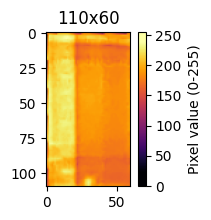

In [14]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import time

## Indicateurs statistiques "basiques"

In [16]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_stats_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des indicateurs statistiques.

In [17]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_stats()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.18 minutes (0.002061912431927735 secondes par module)


## Histogramme

In [18]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_histogram_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les vecteurs histogramme
        histo_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            module.extract_histogram()
            # Stockage du dict histogramme
            histo_dicts.append(module.histogram_dict)
        # On renvoie le dataframe des vecteurs stats
        return pd.DataFrame.from_records(histo_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des histogrammes.

In [19]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_histogram()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.02 minutes (0.0002445434532437087 secondes par module)


## Vecteurs GLCM 

In [20]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [21]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_glcm()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 1.55 minutes (0.0174216066866432 secondes par module)


## Densité de contours

In [22]:
# Transformeur qui renvoie la densité de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = PVModule.get_edge_density_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer la densité de contours pour chaque module PV
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_edge_density()
            edge_densities.append(module.edge_density)
        # On renvoie le dataframe des densités de contours
        return pd.DataFrame(edge_densities, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des densités de contours.

In [23]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_edge_density()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.00 minutes (5.2986630968227506e-05 secondes par module)


## Entropie

In [24]:
# Transformeur qui renvoie les caractéristiques de l'entropie de la matrice de températures du module
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = PVModule.get_entropy_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur de l'entropie
            module.extract_entropy()
            entropy_vectors.append(module.entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame.from_records(entropy_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des cartes d'entropie.

In [25]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_entropy()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.32 minutes (0.00359859159261647 secondes par module)


## Hot spots

In [26]:
# Transformeur qui renvoie les caractéristiques des hot spots de la matrice de températures du module
class HotSpotsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features 'hot spots' à extraire
        self.feature_names_ = PVModule.get_hot_spots_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        hot_spots_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur des caractéristiques des hot spots
            module.extract_hotspots()
            hot_spots_vectors.append(module.hot_spots_features)
        # On renvoie le dataframe des vecteurs des caractéristiques des hot spots
        return pd.DataFrame.from_records(hot_spots_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des hot spots.

In [27]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_hotspots()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.04 minutes (0.0004395468934460408 secondes par module)


# Définition de l'AlbumentationsOverSampler

D'abord on importe la bibliothèque `albumentations`, puis on initialise un dictionnaire qui va mapper l'ensemble des transformations qui nous intéressent avec leur nom.

In [28]:
import albumentations as A

all_transformations = {}

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ToGray".

In [29]:
TRANSFORM_NAME = "ToGray"
COMP_METHODS = ["weighted_average", "from_lab", "desaturation", "average", "max", "pca"]

transformations = {}

for method_name in COMP_METHODS:

    transformation_name = f"{TRANSFORM_NAME}.{method_name}"
    transformation = A.ToGray(num_output_channels=1,
                              method=method_name,
                              p=1.)

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ImageCompression".

In [30]:
TRANSFORM_NAME = "ImgComp"
COMP_METHODS = ["jpeg", "webp"]
TOGRAY_METHODS = {
    "w_avg": "weighted_average",
    "avg": "average",
}
QUALITY = [80, 90]

transformations = {}

for method_name in COMP_METHODS:
    for quality in QUALITY:
        for togray_method_shortname, togray_method_name in TOGRAY_METHODS.items():

            transformation_name = f"{TRANSFORM_NAME}.{method_name}.{quality}.{togray_method_shortname}"
            transformation = A.Compose([
                A.ImageCompression(quality_range=[quality, quality],
                                   compression_type=method_name,                                                                                       
                                   p=1.),
                A.ToGray(num_output_channels=1,
                         method=togray_method_name,
                         p=1.),
            ])

            transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "MedianBlur".

In [31]:
TRANSFORM_NAME = "MedianBlur"
BLUR_LIMITS = [3, 5]

transformations = {}

for blur_limit in BLUR_LIMITS:

    transformation_name = f"{TRANSFORM_NAME}.{blur_limit}"
    transformation = A.Compose([
        A.MedianBlur(blur_limit=[blur_limit, blur_limit],
                            p=1.),
        A.ToGray(num_output_channels=1,
                    method="weighted_average",
                    p=1.),
    ])

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Ici on définit quelles transformations seront appliquées selon la classe de défaut associée à chaque échantillon.

In [32]:
class_transformations = {
    "string short circuit": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
        "ImgComp.jpeg.80.avg",
        "ImgComp.jpeg.90.avg",
        "ImgComp.webp.80.avg", 
        "ImgComp.webp.90.avg", 
        "MedianBlur.3",
    ],
    "break": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
    ],
    "shadow": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "Debris cover": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "bottom dirt": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "short circuit panel": [
        "MedianBlur.3",
    ],
}


In [33]:
import cv2

class AlbumentationsAugmenter:
    
    def __init__(self, 
                 all_transformations: dict,
                 class_transformations: dict,
                 augmented_data_subfolder: str = "augmented",
                 ):
        self.all_transformations = all_transformations
        self.class_transformations = class_transformations
        self.augmented_data_subfolder = augmented_data_subfolder
    
    def augmentation(self, module: PVModule):
        # On récupère la classe du module passé en paramètre
        defect_class = module.status
        # On en déduit la liste des transformations à appliquer
        transformations_list = self.class_transformations.get(defect_class, [])
        # On Récupère les modules "transformés" correspondants
        new_modules = []
        for transformation_name in transformations_list:
            # Définition du chemin de l'image transformée
            class_folder = f"xx{defect_class}"
            new_image_path = (module.image_path.parents[2] 
                              / self.augmented_data_subfolder 
                              / class_folder 
                              / f"{module.image_path.stem}.{transformation_name}.png")
            # Si l'image n'existe pas déjà, on la crée et on la sauvegarde
            if not new_image_path.exists():
                # Transformation
                transformation = self.all_transformations[transformation_name]
                transformed_image = transformation(image=module.color_array)['image']
                # Sauvegarde de l'image transformée
                new_image_path.parent.mkdir(exist_ok=True, parents=True)
                cv2.imwrite(new_image_path, transformed_image)
            # Ensuite on peut charge l'objet PVModule correspondant
            new_modules.append(PVModule.get_module(new_image_path))
        return new_modules

    def resample(self, X, y):
        # On itère sur chaque module du dataset X 
        # pour récupérer le chemin et la classe des nouveaux modules "augmentés"
        all_augmented_modules_dicts = []
        for row in X.itertuples(index=False):
            image_path = Path(row.Chemin)
            module = PVModule.get_module(image_path)
            augmented_modules = self.augmentation(module)
            augmented_modules_dicts = [{
                "Chemin": mod.image_path,
                "Format": mod.format,
                "Train_Test": self.augmented_data_subfolder,
                "Classe": mod.status,
                "Nom": mod.image_path.stem,
            }
                                 for mod in augmented_modules]
            all_augmented_modules_dicts += augmented_modules_dicts

        # On crée le dataframe Xy des modules augmentés
        Xy_augmentation = pd.DataFrame(all_augmented_modules_dicts) 
        # On crée le dataframe X augmenté
        X_augmented = pd.concat([X, Xy_augmentation.drop(columns=["Classe"])], axis=0)
        # On crée le vecteur y augmenté
        y_augmented = pd.concat([y, Xy_augmentation["Classe"]], axis=0)

        return X_augmented, y_augmented
    

On termine en créant le sampler à l'aide de la classe FunctionSampler de la bibliothèque `imblearn`.

In [34]:
from imblearn import FunctionSampler

# Pour que le nom réel du sampler utilisé apparaisse dans l'affichage html du pipeline, 
# on crée une classe 'AlbumentationsOverSampler' qui hérite simplement de la classe 'FunctionSampler' de imblearn
# Au passage, on surcharge la méthode '__str__' pour rendre l'affichage de certains graphes plus lisible
class AlbumentationsOverSampler(FunctionSampler):
    def __str__(self):
        return self.__class__.__name__

albumentations_oversampler = AlbumentationsOverSampler(
    func=AlbumentationsAugmenter(all_transformations, class_transformations).resample,
    validate=False)


# Séparation du jeu de données


Train, Validation & Test.


In [35]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Laisser 'random_state' à None pour obtenir un partage aléatoire non-reproductible

In [36]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [37]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [38]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


## Vérification du fonctionnement du sampler

On vérifie que l'utilisation du sampler permet bien de compenser les classes minoritaires selon les taux d'augmentation définis.

In [39]:
X_train_resampled, y_train_resampled = albumentations_oversampler.fit_resample(X_train, y_train)

In [40]:
display_dataset_proportions(y_train_resampled)

,count,proportion
Classe,,
healthy panel,1165,15.562383
bottom dirt,906,12.102592
Debris cover,804,10.740048
break,728,9.724820
shadow,726,9.698103
string short circuit,684,9.137056
short circuit panel,682,9.110339
hot cell,676,9.030190
junction box heat,640,8.549292


# Modélisation

## Classes complémentaires

### Sélecteur UMAP

A la différence de PCA, UMAP ne prend que des valeurs entières pour le paramètre `n_components`.

Afin d'éviter de demander un nombre de composants supérieur au nombre de features disponibles en entrée, on implémente un transformeur qui adopte le comportement suivant :
- si `n_components` est entier, on le passe tel quel au constructeur UMAP
- si `n_components` est un float, on l'utilise comme ratio du nombre de features initial pour fixer le nombre de features souhaités après réduction

In [41]:
from umap import UMAP
from math import floor

class UMAPSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, **kwargs):
        self.n_components = n_components
        self._umap_n_components = None
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.umap = None
        self._is_fitted = False

    def fit(self, X, y=None):

        if isinstance(self.n_components, float):
            if self.n_components > 1. or self.n_components < 0.:
                raise ValueError("If 'n_components' is a float, it must be in the range [0. 1.]!")
            _n_components = floor(X.shape[1] * self.n_components)
        else:
            _n_components = self.n_components
        
        self._umap_n_components = _n_components
        
        params = self.get_params()
        params["n_components"] = self._umap_n_components
        self.umap = UMAP(**params)
        self.umap.fit(X)

        # Mark as fitted
        self._is_fitted = True

        return self

    def transform(self, X):
        return self.umap.transform(X)
    
    def get_params(self, deep=True):
        # return all attributes that are parameters (sklearn convention)
        return {k: v for k, v in self.__dict__.items()
                if not k.startswith('_') and k not in ['umap']}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [42]:
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        self.classes_ = self.encoder.classes_
        self.n_features_in_ = X.shape[1]
        if hasattr(X, "columns"):
            self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }
    
    @property
    def feature_importances_(self):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.feature_importances_

    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [43]:
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline générique
pipe = Pipeline([
    ('sampler', albumentations_oversampler),
    ('features', FeatureUnion([
        ('stats', BaseStatsExtractor()),
        ('histogram', HistogramExtractor()),
        ('glcm', GLCMExtractor()),
        ("edgedensity", EdgeDensityExtractor()),
        ("entropy", EntropyExtractor()),
        ("hotspots", HotSpotsExtractor()),
    ])),
    ('dropper', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(k="all")),
    ('model', LogisticRegression(max_iter=1000))
],
# Le paramètre 'memory' permet de mettre en cache les transformeurs après entraînement - on gagne du temps sur le GridSearch
# memory="./cache_pipeline",
# L'ajout de .set_output() permet de manipuler des dataframes pandas au lieu de simples arrays numpy à chaque étape
# Cela permet de conserver les noms des colonnes et d'y voir plus clair 
).set_output(transform="pandas")


In [44]:
pipe[:2].fit_transform(X_train, y_train).shape

(7486, 343)

L'extraction de l'ensemble des features possibles conduit à un dataframe de 343 colonnes.

### Paramétrage

Pour une explication de la méthodologie utilisée pour la recherche des meilleurs paramètres des pipelines, voir la section [Méthodologie](#Methodologie) en début de notebook.

#### Samplers

Paramétrage des samplers à évaluer.

In [45]:
sampler_param_grid = [
    {
        'sampler': [albumentations_oversampler],
    },
    {
        'sampler': ["passthrough"],
    },
    # {
    #     'sampler': [
    #         albumentations_oversampler,
    #         "passthrough",
    #         ],
    # },
]

#### Extracteurs

Paramétrage des extracteurs.

In [46]:
extractors_param_grid = [
    {
        "features__stats": [BaseStatsExtractor()],
        "features__edgedensity": [
            EdgeDensityExtractor(),
            "drop",
            ],
        "features__entropy": [
            EntropyExtractor(),
            "drop",
            ],
        "features__glcm": [
            GLCMExtractor(),
            "drop",
            ],
        "features__histogram": [
            # HistogramExtractor(),
            "drop",
            ],
        "features__hotspots": [
            # HotSpotsExtractor(),
            "drop",
            ],
    },
]

#### Scalers

Paramétrage des scalers.

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler_param_grid = [
    {    
        "scaler": [
            "passthrough",
            # StandardScaler().set_output(transform="pandas"),
            # MinMaxScaler().set_output(transform="pandas"),
            # RobustScaler().set_output(transform="pandas"),
        ]
    },
]

#### Selecteurs (Réduction)

Paramétrage de la réduction de dimensions.

In [48]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.decomposition import PCA

selector_param_grid = [
    {
        'selector': ['passthrough'],
    },
    # {
    #     # SelectePercentile : approche similaire à SelectKBest
    #     'selector': [SelectPercentile(mutual_info_classif)],
    #     # 'percentile' permet de déterminer le nombre de features à conserver, en pourcentage du nombre initial
    #     'selector__percentile' : [20, 50, 80],
    #     # 'selector__percentile' : [80],
    # },
    # {
    #     # Analyse en Composantes Principales
    #     'selector': [PCA()],
    #     # 'n_components', si donné en float, permet de choisir le ratio de variance expliquée à conserver
    #     'selector__n_components' : [0.9, 0.95, 0.99],
    # },
    # {
    #     # Uniform Manifold Approximation and Projection
    #     # 'selector': [UMAPSelector(random_state=42)],
    #     'selector': [UMAPSelector()],
    #     # 'n_components' permet de choisir le nombre de noyaux cible (nombre de features au final)
    #     # 'selector__n_components' : [0.5, 0.8, 1.],
    #     'selector__n_components' : [0.5, 0.8],
    #     'selector__n_neighbors' : [5, 10, 15],
    #     'selector__min_dist' : [0.5, 0.8, 0.99],
    # },
]

#### Estimateurs

Paramétrage des estimateurs (modèles).

In [49]:
import numpy as np

# Classifieurs à évaluer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Les classifieurs suivants ont été explorés, mais leurs performances globales (métriques d'intérêt vs temps de calcul) 
# n'ont pas été jugées suffisantes pour qu'ils soient conservés dans le notebook
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier


model_param_grid = [
    {
        'model': [DecisionTreeClassifier()],
        # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
        'model__random_state': [32],
        "model__max_depth": [None, 12],  # Par défaut: None
        # "model__max_depth": [None, 10, 12, 15],  # Par défaut: None
    },
    # {
    #     'model': [RandomForestClassifier()],
    #     # Attention : sans random_state fixe, RandomForest garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__n_estimators': [95],
    #     "model__criterion": ["gini"],
    #     "model__max_depth": [17],
    #     "model__min_samples_split": [2],
    #     "model__min_samples_leaf": [2],
    #     "model__class_weight": ["balanced"],
    #     # Grille d'exploration
    #     # 'model__n_estimators': np.arange(90, 110, 5),
    #     # "model__criterion": ["entropy", "gini", "log_loss"],
    #     # "model__max_depth": [17, 18, 19, 20, None],
    #     # # Paramètres additionnels
    #     # "model__min_samples_split": [2, 5, 10],
    #     # "model__min_samples_leaf": [1, 2, 4],
    #     # "model__class_weight": [None, "balanced"],
    # },
    # {
    #     'model': [DecisionTreeClassifier()],
    #     # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [32],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__max_depth": [12],  # Par défaut: None
    #     "model__min_samples_split": [2],  # Par défaut: 2
    #     "model__min_samples_leaf": [1],  # Par défaut: 1
    #     "model__max_features": [None],  # Par défaut: None
    #     "model__class_weight": [None],  # Par défaut: None
    #     "model__criterion": ["gini"],  # Par défaut: "gini"
    #     # Grille d'exploration
    #     # "model__max_depth": [None, 10, 12, 15, 20],  # Par défaut: None
    #     # "model__min_samples_split": [2, 5, 10, 20, 50],  # Par défaut: 2
    #     # "model__min_samples_leaf": [1, 2, 5, 10, 20],  # Par défaut: 1
    #     # "model__max_features": ["sqrt", "log2", 0.2, 0.5, None],  # Par défaut: None
    #     # "model__class_weight": [None, "balanced"],  # Par défaut: None
    #     # "model__criterion": ["gini", "entropy"],  # Par défaut: "gini"
    # },
    # {
    #     'model': [XGBClassifierWithLabelEncoding()],
    #     # tree_method='auto' et eval_metric='logloss' sont les valeurs par défaut du XGBClassifier
    #     'model__tree_method': ['auto'],
    #     'model__eval_metric': ['logloss'],
    #     # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__max_depth': [6],  # Par défaut: 6
    #     'model__min_child_weight': [1],  # Par défaut: 1
    #     'model__colsample_bytree': [1.],  # Par défaut: 1
    #     'model__subsample': [1.0],  # Par défaut: 1.
    #     'model__learning_rate': [0.3],  # (ou eta) Par défaut: 0.3
    #     'model__n_estimators': [100],  # Par défaut: 100
    #     # Grille d'exploration
    #     # 'model__max_depth': [4, 6, 8],
    #     # 'model__min_child_weight': [1, 6, 12],
    #     # 'model__subsample': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__n_estimators': [100, 200, 300, 500, 600, 700, 800, 900, 1000],
    #     # 'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    # },
    # {
    #     'model': [SVC()],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__C': [10],  # Par défaut: 1.
    #     'model__kernel': ['rbf'],  # Par défaut: 'rbf'
    #     "model__gamma": ["scale"],  # Par défaut: 'scale'
    #     "model__class_weight": ["balanced"],  # Par défaut: None
    #     "model__shrinking": [True],  # Par défaut: True
    #     # Grille d'exploration
    #     # 'model__C': [0.01, 0.1, 1, 10, 100, 1000],
    #     # 'model__kernel': ['linear', 'rbf', 'poly'],
    #     # "model__degree": [2, 3, 4, 5],  # Par défaut: 3 (pour kernel 'poly' seulement)
    #     # "model__gamma": ["scale", "auto", 0.001, 0.1, 0.5, 1.],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__shrinking": [True, False],
    # },
    # {
    #     # Bonnes performances mais plutôt lent
    #     'model': [LGBMClassifier()],
    #     # Paramètres par défaut
    #     "model__objective": ['multiclass'],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__metric": ['multi_logloss'],  # ou 'multi_error'
    #     "model__num_leaves": [127],  # Par défaut: 31
    #     "model__min_data_in_leaf": [20],  # Par défaut: 20
    #     "model__learning_rate": [0.1],  # Par défaut: 0.1
    #     "model__class_weight": [None],  # Par défaut: None
    #     # Grille d'exploration
    #     # "model__num_leaves": [15, 31, 63, 127],
    #     # "model__min_data_in_leaf": [5, 10, 20, 50, 100],
    #     # "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__metric": ['multi_logloss', 'multi_error'],
    # },
    # {
    #     # Très bonnes performances mais plutôt très lent... l'entraînement doit intégrer une part d'auto-optimisation
    #     'model': [CatBoostClassifier()],
    #     # Attention : sans random_seed fixe, CatBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_seed': [32],
    #     # Grille d'exploration
    #     # Inutile : très bonnes performances avec les paramètres par défaut
    # },
]

### Combinaison de l'ensemble des paramètres

In [50]:
param_grids = []

for model_dict in model_param_grid:
    for extractor_dict in extractors_param_grid:
        for scaler_dict in scaler_param_grid:
            for selector_dict in selector_param_grid:
                for sampler_dict in sampler_param_grid:
                    full_dict = {}
                    full_dict.update(model_dict)
                    full_dict.update(extractor_dict)
                    full_dict.update(scaler_dict)
                    full_dict.update(selector_dict)
                    full_dict.update(sampler_dict)
                    param_grids.append(full_dict)

In [51]:
len(param_grids)

2

### Fonctions d'extraction des caractéristiques du pipeline

In [52]:
# Type de modèle
def extract_model_name(pipeline):
    model = pipeline[5]
    return model.__class__.__name__ if model is not None else 'unknown'

# Sampler
def extract_sampler_name(pipeline):
    sampler = pipeline[0]
    return sampler.__class__.__name__ if not isinstance(sampler, str) else 'noSampling'

# Extracteurs / Features
def extract_extractor_names(pipeline):
    extractors_dict = pipeline[1].named_transformers
    extractor_strings = []
    for feature_key, extractor in extractors_dict.items():
        extractor_string = feature_key.capitalize()
        extractor_string = f"no{extractor_string}" if isinstance(extractor, str) else extractor_string
        extractor_strings.append(extractor_string)
    return "_".join(extractor_strings)

# Scaler
def extract_scaler_name(pipeline):
    scaler = pipeline[3]
    return scaler.__class__.__name__ if not isinstance(scaler, str) else 'noScaling'

# Selector
def extract_selector_name(pipeline):
    selector = pipeline[4]
    return selector.__class__.__name__ if not isinstance(selector, str) else 'noReduction'

# Concaténation de l'ensemble des caractéristiques
def get_pipeline_shortdescription(pipeline):

    model_name = extract_model_name(pipeline)
    sampler_name = extract_sampler_name(pipeline)
    features = extract_extractor_names(pipeline)
    scaler_name = extract_scaler_name(pipeline)
    selector_name = extract_selector_name(pipeline)
    
    return f"{model_name}_{sampler_name}_{features}_{scaler_name}_{selector_name}"


## Activation de MLflow

In [53]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:

    import mlflow
    import logging

    # Configuration du serveur MLflow
    mlflow.set_tracking_uri(MLFLOW_URI)

    # Définition des noms des Experiments
    MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{suffix}"

    # Suppression des messages de log émis par MLflow
    mlflow_logger = logging.getLogger('mlflow')
    mlflow_logger.setLevel(logging.WARNING)
    logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
    

## Validation croisée

### Fonction d'exécution du GridSearchCV

In [54]:
import time
import tempfile
from pprint import pprint
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Exécution du GridSearch
def execute_gridsearch(pipeline_param_grid):

    start = time.time()

    base_model = pipeline_param_grid.get('model')[0]
    model_name = base_model.__class__.__name__
    
    print("-------------------------------------------------------------------------")
    print(f"Evaluation des pipelines basés sur {model_name}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=pipeline_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=1)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)

    # Ajout de la description macro de chaque pipeline évalué
    for idx, params in results['params'].items():
        c_pipe = clone(grid.estimator)
        c_pipe.set_params(**params)
        c_pipe_description = get_pipeline_shortdescription(c_pipe)
        results.loc[idx, "pipeline_description"] = c_pipe_description

    # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
    best_idx = grid.best_index_
    n_features_pre_selector = grid.best_estimator_[:4].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_pre_selector"] = n_features_pre_selector
    n_features_post_selector = grid.best_estimator_[:5].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_post_selector"] = n_features_post_selector

    # Affichage des résultats
    display(results[['pipeline_description',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    return grid, results


### Fonctions de log de MLflow

In [55]:
if ACTIVATE_MLFLOW:

    import mlflow.sklearn
    import mlflow.sklearn.utils

    def mlflow_log_standard(current_results, i):
        """Log info for standard run"""

        params = current_results.loc[i, 'params']

        # Log pipeline description as tag
        mlflow.set_tag("description", current_results.loc[i, "pipeline_description"])

        # Log hyperparameters
        mlflow.log_params(params)

        # Log mean and std scores, mean and std times, ranks, split_scores, n_features
        for name in current_results.columns:
            if name.startswith(("mean_test_", "rank_test_", "std_test_", "n_features_")) or name.endswith("_time"):
                mlflow.log_metric(name, current_results.loc[i, name])

        mlflow.set_tag("is_best", False)


    def mlflow_log_best(child_run, current_results, i, current_grid, figure=None, report_text=None, report_dict=None):
        """Log info for best run"""

        # Log the model
        best_model = current_grid.best_estimator_
        mlflow.sklearn.log_model(best_model, artifact_path="model", input_example=X_train[["Chemin"]])
        mlflow.set_tag("is_best", True)

        # Log pipeline html representation
        mlflow.sklearn.utils._log_estimator_html(child_run.info.run_id, best_model)

        # Log test metrics, if any
        for score_name in [name for name in current_results.columns if name.startswith("test_")]:
            mlflow.log_metric(score_name, current_results.loc[i, score_name])
        
        # Log classification matrix
        if figure is not None:
            with tempfile.TemporaryDirectory() as tmp_dir:
                cm_path = Path(tmp_dir) / "confusion_matrix.png"
                figure.savefig(cm_path)
                mlflow.log_artifact(cm_path)
        
        # Log classification reports
        if report_text is not None:
            mlflow.log_text(report_text, "classification_report.txt")
        if report_dict is not None:
            mlflow.log_dict(report_dict, "classification_report.yaml")

        mlflow.set_tag("is_best", True)


### Exécution du GridSearchCV

In [57]:
from joblib import parallel_backend
from sklearn.exceptions import ConvergenceWarning
import warnings

results_list = []

# mlflow_client = mlflow.tracking.MlflowClient()

for param_idx, param_grid in enumerate(param_grids):

    print()
    print(f"Param_grid {param_idx+1}/{len(param_grids)}")

    # with parallel_backend('loky'):  # Paramétrage par défaut - multiprocessing
    with parallel_backend('threading'):  # Important pour permettre le "partage" de la classe PVModule entre tous les jobs

        with warnings.catch_warnings():

            # Filtrage des ConvergenceWarnings émis par scikit-learn pour LogisticRegression
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            # Filtrage des FutureWarnings émis par scikit-learn / En version <=0.5.7, UMAP utilise un nom de paramètre prochainement déprécié
            warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", message=r"^'force_all_finite' was renamed.*")
            # Filtrage des UserWarnings émis par joblib (probablement une opération de lecture du cache qui dure trop longtemps)
            warnings.filterwarnings("ignore", category=UserWarning, module="joblib", message=r"^Persisting input arguments took.*")
        
            # Exécution du GridSearchCV
            current_grid, current_results = execute_gridsearch(param_grid)

    # Ajout des résultats courants à la liste
    results_list.append(current_results)

    if ACTIVATE_MLFLOW:

        base_model = param_grid.get('model')[0]
        model_name = base_model.__class__.__name__
        
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=model_name,
                                                                    # date_string=current_dt.format('YYYYMMDD_HHmm'),
                                                                    # date_string=current_dt.format('YYYYMMDD'),
                                                                    )
                              )
        mlflow.set_experiment_tag("estimator", model_name)

        with mlflow.start_run() as parent_run:

            n_candidates = len(current_results['params'])
            best_index = current_grid.best_index_

            # Log de la grille de paramètres et des paramètres additionnels
            mlflow.log_params(param_grid)
            mlflow.log_param("cv", current_grid.cv)
            mlflow.log_param("scoring", current_grid.scoring)
            mlflow.log_param("total_candidates", n_candidates)

            # Log du dataframe de l'ensemble des résultats
            with tempfile.TemporaryDirectory() as tmp_dir:
                results_path = Path(tmp_dir) / "cv_results.csv"
                current_results.to_csv(results_path, index=False)
                mlflow.log_artifact(results_path)

            for i in range(n_candidates):

                # Si on ne souhaite logger que le "best run"
                if i == best_index:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)
                        mlflow_log_best(child_run, current_results, i, current_grid)

                # Si on souhaite logger tous les runs
                elif MLFLOW_LOG_ALL_RUNS:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)




Param_grid 1/2
-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Temps nécessaire : 0.57 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000002459E85DAF0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'model__random_state': [32],
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000002459E85DAF0>>,
                                                               validate=False)],
                         'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(),
 'model__max_depth': 12,
 'model__random_state': 32,
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000002459E85DAF0>>,
                          validate=False),
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.5725982344094508


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
5,DecisionTreeClassifier_AlbumentationsOverSampl...,1,{'features__edgedensity': EdgeDensityExtractor...,3.753226,0.527880,0.649649,0.012942,0.572598,0.015356
1,DecisionTreeClassifier_AlbumentationsOverSampl...,2,{'features__edgedensity': EdgeDensityExtractor...,4.607689,0.714390,0.646136,0.014985,0.567531,0.020930
13,DecisionTreeClassifier_AlbumentationsOverSampl...,3,"{'features__edgedensity': 'drop', 'features__e...",3.718193,0.198227,0.628337,0.016503,0.563399,0.019017
9,DecisionTreeClassifier_AlbumentationsOverSampl...,4,"{'features__edgedensity': 'drop', 'features__e...",4.029264,0.264518,0.634895,0.020847,0.558917,0.024918
4,DecisionTreeClassifier_AlbumentationsOverSampl...,5,{'features__edgedensity': EdgeDensityExtractor...,3.779193,0.617611,0.615222,0.007428,0.552364,0.006157
0,DecisionTreeClassifier_AlbumentationsOverSampl...,6,{'features__edgedensity': EdgeDensityExtractor...,4.854693,0.832943,0.614754,0.007661,0.547967,0.014309
12,DecisionTreeClassifier_AlbumentationsOverSampl...,7,"{'features__edgedensity': 'drop', 'features__e...",4.455157,0.197837,0.610304,0.010614,0.546275,0.015803
8,DecisionTreeClassifier_AlbumentationsOverSampl...,8,"{'features__edgedensity': 'drop', 'features__e...",4.583314,0.355507,0.609836,0.026552,0.544895,0.032366
3,DecisionTreeClassifier_AlbumentationsOverSampl...,9,{'features__edgedensity': EdgeDensityExtractor...,3.928086,0.537641,0.618970,0.010696,0.539447,0.019806
7,DecisionTreeClassifier_AlbumentationsOverSampl...,10,{'features__edgedensity': EdgeDensityExtractor...,3.048136,0.472500,0.613817,0.026083,0.535821,0.025308



Param_grid 2/2
-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Temps nécessaire : 0.28 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000002459E85DAF0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'features__hotspots': ['drop'],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [DecisionTreeClassifier(max_depth=12,
                                                          random_state=32)],
                         'model__max_depth': [None, 12],
                         'model__random_state': [32],
                         'sampler': ['passthrough'], 'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(max_depth=12, random_state=32),
 'model__max_depth': 12,
 'model__random_state': 32,
 'sampler': 'passthrough',
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.6040569477967261


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
5,DecisionTreeClassifier_noSampling_Stats_noHist...,1,{'features__edgedensity': EdgeDensityExtractor...,1.177716,0.567493,0.692506,0.015492,0.604057,0.022655
13,DecisionTreeClassifier_noSampling_Stats_noHist...,2,"{'features__edgedensity': 'drop', 'features__e...",0.935002,0.399331,0.679391,0.007157,0.601530,0.009364
4,DecisionTreeClassifier_noSampling_Stats_noHist...,3,{'features__edgedensity': EdgeDensityExtractor...,1.030844,0.504952,0.671429,0.012861,0.590137,0.024117
0,DecisionTreeClassifier_noSampling_Stats_noHist...,4,{'features__edgedensity': EdgeDensityExtractor...,1.761875,0.907586,0.666511,0.012664,0.585836,0.019993
1,DecisionTreeClassifier_noSampling_Stats_noHist...,5,{'features__edgedensity': EdgeDensityExtractor...,1.665772,0.528970,0.681967,0.014730,0.578426,0.023675
12,DecisionTreeClassifier_noSampling_Stats_noHist...,6,"{'features__edgedensity': 'drop', 'features__e...",0.929249,0.445004,0.662529,0.012155,0.576927,0.017647
9,DecisionTreeClassifier_noSampling_Stats_noHist...,7,"{'features__edgedensity': 'drop', 'features__e...",1.344249,0.579393,0.670960,0.018216,0.575168,0.015353
3,DecisionTreeClassifier_noSampling_Stats_noHist...,8,{'features__edgedensity': EdgeDensityExtractor...,1.211524,0.632241,0.673068,0.018237,0.572510,0.014852
8,DecisionTreeClassifier_noSampling_Stats_noHist...,9,"{'features__edgedensity': 'drop', 'features__e...",1.686724,0.508795,0.647775,0.016164,0.571781,0.020257
7,DecisionTreeClassifier_noSampling_Stats_noHist...,10,{'features__edgedensity': EdgeDensityExtractor...,0.964022,0.521614,0.664169,0.026386,0.561897,0.027009


## Compilation des résultats

In [58]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True).sort_values("mean_test_f1_macro", ascending=False)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,split0_train_f1_macro,split1_train_f1_macro,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector
21,1.177716,0.059246,0.567493,0.116788,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.877729,0.898237,0.910899,0.890094,0.890494,0.893490,0.010904,DecisionTreeClassifier_noSampling_Stats_noHist...,49.0,49.0
29,0.935002,0.178335,0.399331,0.125130,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.909805,0.905117,0.905278,0.902453,0.914641,0.907459,0.004298,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
20,1.030844,0.134762,0.504952,0.174097,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
16,1.761875,0.023613,0.907586,0.182490,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
17,1.665772,0.021169,0.528970,0.139129,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.860054,0.899593,0.918023,0.884218,0.895075,0.891393,0.019097,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
28,0.929249,0.135979,0.445004,0.167277,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
25,1.344249,0.136265,0.579393,0.110587,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.886510,0.885076,0.932693,0.902018,0.889683,0.899196,0.017781,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
5,3.753226,0.030643,0.527880,0.103612,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.834215,0.827827,0.845953,0.826372,0.836192,0.834112,0.006985,DecisionTreeClassifier_AlbumentationsOverSampl...,49.0,49.0
19,1.211524,0.036313,0.632241,0.138514,EdgeDensityExtractor(),EntropyExtractor(),drop,drop,drop,BaseStatsExtractor(),...,0.847204,0.853895,0.892365,0.859820,0.876949,0.866046,0.016450,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
24,1.686724,0.108950,0.508795,0.056036,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN


## Sauvegarde du fichier de résultats

Dans le cas où MLflow n'est pas utilisé, on peut stocker l'ensemble des résultats de recherche dans des fichiers nommés en fonction de la date et de l'heure d'exécution.

In [59]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
print(f"Sauvegarde du fichier {filepath}")
results_df.to_csv(filepath, index=False, sep=";")

Sauvegarde du fichier ML_stats_results\results_20250624_1939.csv


# Exploration des résultats

In [60]:
results_df['model_name'] = results_df['param_model'].apply(lambda model_object: model_object.__class__.__name__)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [61]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector,model_name,params_str
21,1.177716,0.059246,0.567493,0.116788,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.910899,0.890094,0.890494,0.893490,0.010904,DecisionTreeClassifier_noSampling_Stats_noHist...,49.0,49.0,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
29,0.935002,0.178335,0.399331,0.125130,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.905278,0.902453,0.914641,0.907459,0.004298,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
20,1.030844,0.134762,0.504952,0.174097,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
16,1.761875,0.023613,0.907586,0.182490,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
17,1.665772,0.021169,0.528970,0.139129,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.918023,0.884218,0.895075,0.891393,0.019097,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
28,0.929249,0.135979,0.445004,0.167277,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
25,1.344249,0.136265,0.579393,0.110587,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.932693,0.902018,0.889683,0.899196,0.017781,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
5,3.753226,0.030643,0.527880,0.103612,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.845953,0.826372,0.836192,0.834112,0.006985,DecisionTreeClassifier_AlbumentationsOverSampl...,49.0,49.0,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
19,1.211524,0.036313,0.632241,0.138514,EdgeDensityExtractor(),EntropyExtractor(),drop,drop,drop,BaseStatsExtractor(),...,0.892365,0.859820,0.876949,0.866046,0.016450,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
24,1.686724,0.108950,0.508795,0.056036,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...


In [62]:
import plotly.express as px

def display_graphs(results_df, scores, x_axis, score_of_interest):

    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score_of_interest].idxmax()

    results_df_highlight = results_df.copy()
    results_df_highlight["highlight"] = results_df_highlight.index == best_idx
    results_df_highlight = results_df_highlight.sort_values("highlight")

    # Création du graphique interactif pour chaque cas
    for score, title in scores.items():

        size_column = score.replace("mean", "std")
        size_column = size_column if size_column in results_df_highlight.columns else None

        fig = px.scatter(
            results_df_highlight,
            x=x_axis,
            y=score,
            color='highlight',
            size=size_column,
            hover_data={
                'model_name': True,
                'params_str': True,
                x_axis: ':.2f',
                score: ':.4f',
            },
            title=title,
        )
        fig.update_traces(showlegend=False)
        fig.show()


In [63]:
import plotly.express as px

# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "Précision vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
    "mean_test_f1_macro": "F1_macro vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
}

SCORE_OF_INTEREST = "mean_test_f1_macro"

# Trouver l’indice du meilleur modèle
best_idx = results_df[SCORE_OF_INTEREST].idxmax()

results_df["highlight"] = results_df.index == best_idx

# Création du graphique interactif pour chaque cas
for score, title in scores.items():

    size_column = score.replace("mean", "std")
    size_column = size_column if size_column in results_df.columns else None

    fig = px.scatter(
        results_df.sort_values("highlight"),
        x="mean_fit_time",
        y=score,
        color='highlight',
        size=size_column,
        hover_data={
            'model_name': True,
            'params_str': True,
            "mean_fit_time": ':.2f',
            score: ':.4f',
        },
        title=title,
    )
    fig.update_traces(showlegend=False)
    fig.show()


# Conclusions intermédiaires

Dans cette section on présente les paramètres qui sont ressortis de l'étude des différents pipe

## Influence de l'augmentation de données

Il apparaît que la technique d'augmentation de données choisie n'apporte pas d'amélioration.

Il aurait pu être utile de la comparer aux techniques "classiques" d'oversampling telles que SMOTE ou ADASYN, mais cela n'a pas été expérimenté.

## Features pertinents

En complément des indicateurs statistiques basiques, il apparaît que les features les plus pertinents sont les suivants :
1. **GLCM (Gray-Level Co-occurence Matrix)** : les caractéristiques statistiques extraites de la matrice GLCM, qui représente la fréquence d'apparition de paires de pixels ayant des valeurs de gris spécifiques, à une certaine distance et direction l’un par rapport à l’autre. C'est d'une certaine façon une analyse de la texture d'une image.
   - Les caractéristiques GLCM sont utiles pour tous les classifieurs
2. **EdgeDensity** : la densité de contours. Bien que l'extraction de cette information ne produise qu'une seule donnée dans l'ensemble des features, elle se révèle très pertinente.
   - L'information EdgeDensity est utile pour tous les classifieurs
3. **Entropy** : les caractéristiques d'entropie de l'image. C'est une analyse de la complexité de l'image.
   - Les caractéristiques Entropy sont utiles pour certains classifieurs, mais pas tous
4. **HotSpots** : ces informations permettent de caractériser les points chauds de l'image (nombre, moyenne et écart-type des surfaces, moyenne et écart-type des valeurs, etc.)
   - Les informations HotSpots sont rarement utiles (utilisées par un seul classifieur : RandomForest). L'extraction de ces informations a été ajouté au cours de la phase de modélisation. C'est une approche particulièrement liée au domaine "métier" de notre problème : il pourrait être utile de travailler cette approche utilisant les points chauds pour améliorer sa pertinence.

L'**histogramme** de l'image, quant à lui, ne s'est jamais avéré pertinent. Il a été calculé sur les 255 valeurs possibles des pixels de l'image, sans regroupement des valeurs (de 10 en 10 par exemple). Il est possible que l'information qu'il contient 


## Utilité de la réduction de dimensions

La réduction de dimension de type PCA ou UMAP ne s'est jamais révélée utile : au contraire, à pipelines identiques "tous paramètres égaux par ailleurs", les résultats obtenus apparaissent moins bons entre un pipeline qui n'utilise aucune réduction et un pipeline qui utilise une PCA (quelle que soit la cible sur le taux de variance expliquée) ou une UMAP (quel que soit le nombre de composantes cible).

La sélection du nombre de features par un algorithme SelectPercentiles'est avérée utile pour 2 classifieurs : SVC et CatBoost.

# Meilleur pipeline par classifieur

## Paramètres des meilleurs pipelines

Le dictionnaire défini ci-après rassemble les meilleurs pipelines obtenus : le meilleur pipeline (celui ayant permis d'obtenir les meilleurs résultats sur notre jeu de données par la recherche GridSearchCV) pour chacun des classifieurs évalués.

In [56]:
best_pipelines = {}

### RandomForest

In [57]:
best_pipelines["RandomForest"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": HotSpotsExtractor(),
    "scaler": MinMaxScaler(),
    "selector": "passthrough",
    "model": RandomForestClassifier(),
    # Attention : sans random_state fixe, RandomForest garde une part d"aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__n_estimators": 95,
    "model__criterion": "gini",
    "model__max_depth": 17,
    "model__min_samples_split": 2,
    "model__min_samples_leaf": 2,
    "model__class_weight": "balanced",
}

### DecisionTree

In [58]:
best_pipelines["DecisionTree"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": RobustScaler(),
    "selector": "passthrough",
    "model": DecisionTreeClassifier(),
    # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 32,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 12,
    "model__min_samples_split": 2,
    "model__min_samples_leaf": 1,
    "model__max_features": None,
    "model__class_weight": None,
    "model__criterion": "gini",
}

### XGBoost

In [59]:
best_pipelines["XGBoost"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    "selector": "passthrough",
    "model": XGBClassifierWithLabelEncoding(),
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": "auto",
    "model__eval_metric": "logloss",
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 6,
    "model__min_child_weight": 1,
    "model__colsample_bytree": 1.,
    "model__subsample": 1.0,
    "model__learning_rate": 0.3,
    "model__n_estimators": 100,
}

### SVC

In [60]:
best_pipelines["SVC"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": StandardScaler(),
    "selector": SelectPercentile(mutual_info_classif),
    "selector__percentile" : 80,
    "model": SVC(),
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__C": 10,
    "model__kernel": "rbf",
    "model__gamma": "scale",
    "model__class_weight": "balanced",
    "model__shrinking": True,
}

### LightGBM

In [61]:
best_pipelines["LightGBM"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    "selector": "passthrough",
    'model': LGBMClassifier(),
    # Paramètres par défaut
    "model__objective": 'multiclass',
    # Paramètres optimaux trouvés lors de la phase exploratoire (souvent les paramètres par défaut)
    "model__metric": 'multi_logloss',
    "model__num_leaves": 127,
    "model__min_data_in_leaf": 20,
    "model__learning_rate": 0.1,
    "model__class_weight": None,
}

### CatBoost

In [62]:
best_pipelines["CatBoost"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    # "selector": "passthrough",
    "selector": SelectPercentile(mutual_info_classif),
    "selector__percentile" : 80,
    "model": CatBoostClassifier(),
    # Attention : sans random_seed fixe, CatBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_seed": 12,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    # Paramètres par défaut
}

## Fonction de comparaison

In [63]:
# La variable globale suivante permet d'activer ou non la vidange du cache de la classe PVModule
PVMODULE_EMPTY_VAULT = True

In [64]:
from copy import deepcopy

def get_test_results(best_pipelines: dict, best_pipelines_results: pd.DataFrame, split_name: str):

    for estimator_name, params in best_pipelines.items():

        print()
        print("-----------------------------------------------------------------------------------------")
        print(f"Evaluation du meilleur pipeline basé sur {estimator_name} pour le split {split_name}")
        print("-----------------------------------------------------------------------------------------")
        print()

        # Vidange du cache de la classe PVModule - permet de repartir d'une situation initiale "vierge" pour chaque pipeline
        if PVMODULE_EMPTY_VAULT:
            PVModule.empty_vault()

        # Enregistrement du split
        best_pipelines_results.loc[estimator_name, "dataset_split"] = split_name

        # Configuration du pipeline
        pipeline_params = deepcopy(params)
        pipe.set_params(**pipeline_params)

        # Entraînement #
        ################

        # Pre-processing
        start = time.time()
        X_train_transformed = pipe[:5].fit_transform(X_train, y_train)
        end = time.time()
        train_preproc_time = end - start
        print(f"Entraînement - Temps de pre-processing: {train_preproc_time:.2f} secondes")

        # Entraînement
        start = time.time()
        pipe[5].fit(X_train_transformed, y_train)
        end = time.time()
        train_fit_time = end - start
        print(f"Entraînement - Temps de fit: {train_fit_time:.2f} secondes")

        # Entraînement - Temps total
        total_train_time = train_preproc_time + train_fit_time
        print(f"Temps total d'entraînement (pre-processing + fit): {total_train_time:.2f} secondes")

        # Affichage
        display(pipe)

        # Prédictions #
        ###############

        # Pre-processing
        start = time.time()
        X_test_transformed = pipe[:5].transform(X_test)
        end = time.time()
        predict_preproc_time = end - start
        print(f"Prédiction - Temps de pre-processing: {predict_preproc_time:.2f} secondes")

        # Calcul des prédictions sur le jeu de test
        start = time.time()
        y_test_pred = pipe[5].predict(X_test_transformed)
        end = time.time()
        predict_pred_time = end - start
        print(f"Prédiction - Temps de prédiction: {predict_pred_time:.2f} secondes")

        # Prédiction - Temps total
        total_pred_time = predict_preproc_time + predict_pred_time
        print(f"Temps total de prédiction (pre-processing + prediction): {total_pred_time:.2f} secondes")

        # Calcul des scores
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
        test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
        test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
        test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
        test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
        test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")
        
        # Ajout des scores obtenus dans le dataframe final
        best_pipelines_results.loc[estimator_name, "test_accuracy"] = test_accuracy
        best_pipelines_results.loc[estimator_name, "test_f1_macro"] = test_f1_macro
        best_pipelines_results.loc[estimator_name, "test_f1_weighted"] = test_f1_weighted
        best_pipelines_results.loc[estimator_name, "test_recall_macro"] = test_recall_macro
        best_pipelines_results.loc[estimator_name, "test_recall_weighted"] = test_recall_weighted
        best_pipelines_results.loc[estimator_name, "test_precision_macro"] = test_precision_macro
        best_pipelines_results.loc[estimator_name, "test_precision_weighted"] = test_precision_weighted

        # Ajout des temps
        best_pipelines_results.loc[estimator_name, "train_preproc_time"] = train_preproc_time
        best_pipelines_results.loc[estimator_name, "train_fit_time"] = train_fit_time
        best_pipelines_results.loc[estimator_name, "total_train_time"] = total_train_time
        best_pipelines_results.loc[estimator_name, "predict_preproc_time"] = predict_preproc_time
        best_pipelines_results.loc[estimator_name, "predict_pred_time"] = predict_pred_time
        best_pipelines_results.loc[estimator_name, "total_pred_time"] = total_pred_time

        # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
        n_features_pre_selector = pipe[:4].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_pre_selector"] = n_features_pre_selector
        n_features_post_selector = pipe[:5].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_post_selector"] = n_features_post_selector

        # Affichage des résultats
        print()
        print("-------------------------------------------------------")
        print(f"Résultats obtenus sur le jeu de test du split {split_name} :")

        cm_figure, cr_text, cr_dict = display_results(y_test, y_test_pred)

        if ACTIVATE_MLFLOW:

            base_model = params.get('model')
            model_name = base_model.__class__.__name__
            
            mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=f"{split_name}_BestPipelines"))

            with mlflow.start_run() as current_run:

                # Log model name as tag
                mlflow.set_tag("model", model_name)
                
                # Log hyperparameters
                mlflow.log_params(params)

                # Log all metrics
                for name in best_pipelines_results.columns:
                    mlflow.log_metric(name, best_pipelines_results.loc[estimator_name, name])

                # Log the model
                mlflow.sklearn.log_model(pipe, artifact_path="model", input_example=X_train[["Chemin"]])

                # Log pipeline html representation
                mlflow.sklearn.utils._log_estimator_html(current_run.info.run_id, pipe)

                # Log classification matrix
                with tempfile.TemporaryDirectory() as tmp_dir:
                    cm_path = Path(tmp_dir) / "confusion_matrix.png"
                    cm_figure.savefig(cm_path)
                    mlflow.log_artifact(cm_path)
                    
                # Log classification reports
                mlflow.log_text(cr_text, "classification_report.txt")
                mlflow.log_dict(cr_dict, "classification_report.yaml")

## Fonction d'affichage des graphes

In [65]:
import plotly.express as px
import plotly.graph_objects as go

def display_best_pipelines_graphs(best_pipelines_results):

    best_pipelines_results['pipeline_name'] = best_pipelines_results.index

    title_suffix = "<br>Attention, les temps affichés varient selon la machine utilisée"
    if PVMODULE_EMPTY_VAULT:
        title_suffix += "<br>Cache préprocessing : <span style='color:red'>désactivé</span>"
    else:
        title_suffix += "<br>Cache préprocessing : <span style='color:red'>activé</span>"

    # Création du graphique interactif 'score vs total_fit_time'
    for score, title in scores.items():

        fig = px.scatter(
            best_pipelines_results,
            x="total_train_time",
            y=score,
            color="pipeline_name",
            hover_data={
                'pipeline_name': True,
                "total_train_time": ':.2f',
                score: ':.4f',
            },
            title=title + title_suffix,
        )
        fig.update_traces(showlegend=True)
        fig.update_traces(marker=dict(size=10))
        fig.show()

    # Création du bargraph interactif 'times per estimator'
    fig = go.Figure()

    for step_time in ["train_preproc_time", "train_fit_time", "predict_preproc_time", "predict_pred_time"]:
        fig.add_trace(go.Bar(
            y=best_pipelines_results["pipeline_name"],
            x=best_pipelines_results[step_time],
            orientation='h',
            name=step_time,
        ))

    fig.update_layout(
        barmode='stack',
        title="Temps de pre-processing, entraînement et prédiction par estimateur" + title_suffix,
        )
    fig.show()

## Résultats sur le jeu de test

Juste par précaution, parce que ce notebook est utilisé en faisant des allers-retours entre les différentes parties : on s'assure qu'on utilise toujours le même split 80/20 de travail, sans les images 'doute_carre'.

In [66]:
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=True)

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 4270
Nb d'images dans l'ensemble de test : 1068



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur RandomForest pour le split 80.20
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 91.88 secondes
Entraînement - Temps de fit: 2.07 secondes
Temps total d'entraînement (pre-processing + fit): 93.95 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots',
                                                 HotSpotsExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', MinMaxScaler()),
                ('selector', 'passthrough'),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=17,
                                        min_samples_leaf=2, n_estimators=95,
                                        random_state=42))])

Prédiction - Temps de pre-processing: 25.47 secondes
Prédiction - Temps de prédiction: 0.02 secondes
Temps total de prédiction (pre-processing + prediction): 25.48 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


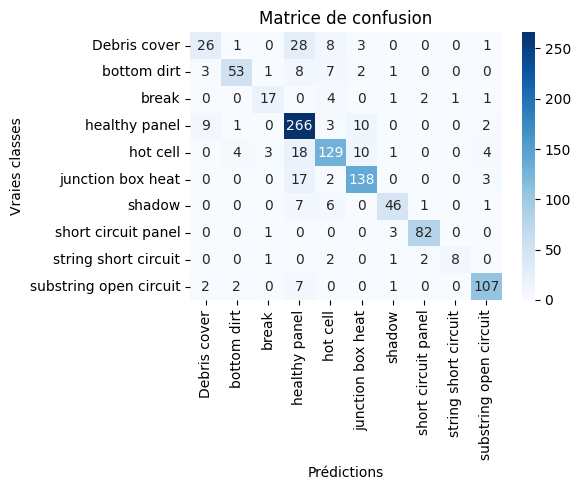

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.65      0.39      0.49        67
           bottom dirt       0.87      0.71      0.78        75
                 break       0.74      0.65      0.69        26
         healthy panel       0.76      0.91      0.83       291
              hot cell       0.80      0.76      0.78       169
     junction box heat       0.85      0.86      0.85       160
                shadow       0.85      0.75      0.80        61
   short circuit panel       0.94      0.95      0.95        86
  string short circuit       0.89      0.57      0.70        14
substring open circuit       0.90      0.90      0.90       119

              accuracy                           0.82      1068
             macro avg       0.82      0.75      0.78      1068
          weighted avg       0.82      0.82      0.81      1068


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', RobustScaler()),
                ('selector', 'passthrough'),
                ('model',
                 DecisionTreeClassifier(max_depth=12, random_state=32))])

Prédiction - Temps de pre-processing: 22.87 secondes
Prédiction - Temps de prédiction: 0.00 secondes
Temps total de prédiction (pre-processing + prediction): 22.87 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


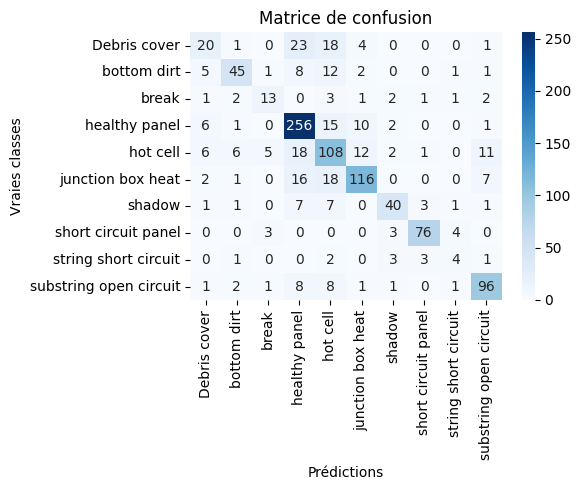

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.48      0.30      0.37        67
           bottom dirt       0.75      0.60      0.67        75
                 break       0.57      0.50      0.53        26
         healthy panel       0.76      0.88      0.82       291
              hot cell       0.57      0.64      0.60       169
     junction box heat       0.79      0.72      0.76       160
                shadow       0.75      0.66      0.70        61
   short circuit panel       0.90      0.88      0.89        86
  string short circuit       0.33      0.29      0.31        14
substring open circuit       0.79      0.81      0.80       119

              accuracy                           0.72      1068
             macro avg       0.67      0.63      0.64      1068
          weighted avg       0.72      0.72      0.72      1068


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 XG...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 29.56 secondes
Prédiction - Temps de prédiction: 0.01 secondes
Temps total de prédiction (pre-processing + prediction): 29.57 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


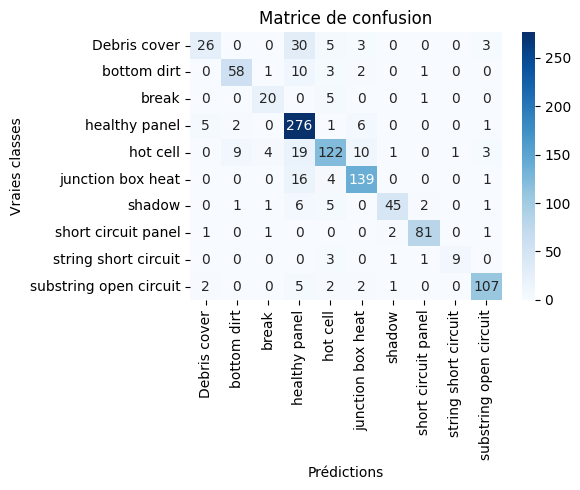

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.76      0.39      0.51        67
           bottom dirt       0.83      0.77      0.80        75
                 break       0.74      0.77      0.75        26
         healthy panel       0.76      0.95      0.85       291
              hot cell       0.81      0.72      0.76       169
     junction box heat       0.86      0.87      0.86       160
                shadow       0.90      0.74      0.81        61
   short circuit panel       0.94      0.94      0.94        86
  string short circuit       0.90      0.64      0.75        14
substring open circuit       0.91      0.90      0.91       119

              accuracy                           0.83      1068
             macro avg       0.84      0.77      0.80      1068
          weighted avg       0.83      0.83      0.82      1068


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x00000153788884A0>)),
                ('model', SVC(C=10, class_weight='balanced'))])

Prédiction - Temps de pre-processing: 27.70 secondes
Prédiction - Temps de prédiction: 0.18 secondes
Temps total de prédiction (pre-processing + prediction): 27.89 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


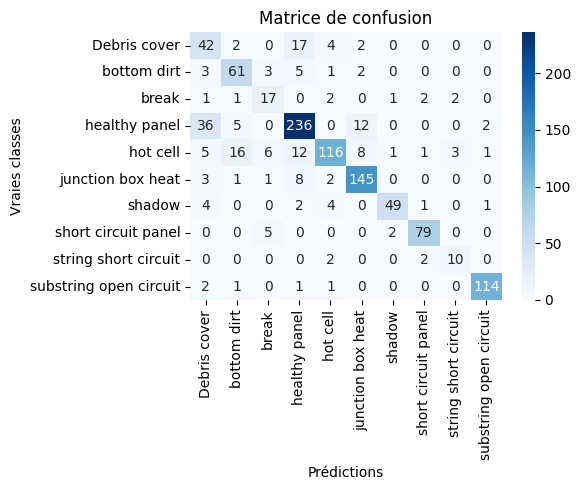

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.44      0.63      0.52        67
           bottom dirt       0.70      0.81      0.75        75
                 break       0.53      0.65      0.59        26
         healthy panel       0.84      0.81      0.83       291
              hot cell       0.88      0.69      0.77       169
     junction box heat       0.86      0.91      0.88       160
                shadow       0.92      0.80      0.86        61
   short circuit panel       0.93      0.92      0.92        86
  string short circuit       0.67      0.71      0.69        14
substring open circuit       0.97      0.96      0.96       119

              accuracy                           0.81      1068
             macro avg       0.77      0.79      0.78      1068
          weighted avg       0.83      0.81      0.82      1068


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20,
                                num_leaves=127, objective='multiclass'))])

Prédiction - Temps de pre-processing: 29.50 secondes
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Prédiction - Temps de prédiction: 0.03 secondes
Temps total de prédiction (pre-processing + prediction): 29.52 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


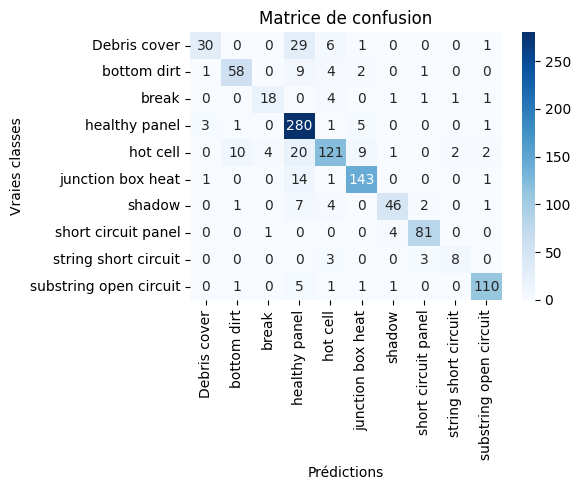

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.86      0.45      0.59        67
           bottom dirt       0.82      0.77      0.79        75
                 break       0.78      0.69      0.73        26
         healthy panel       0.77      0.96      0.85       291
              hot cell       0.83      0.72      0.77       169
     junction box heat       0.89      0.89      0.89       160
                shadow       0.87      0.75      0.81        61
   short circuit panel       0.92      0.94      0.93        86
  string short circuit       0.73      0.57      0.64        14
substring open circuit       0.94      0.92      0.93       119

              accuracy                           0.84      1068
             macro avg       0.84      0.77      0.79      1068
          weighted avg       0.84      0.84      0.83      1068


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x00000153788884A0>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000153B14171A0>)])

Prédiction - Temps de pre-processing: 23.19 secondes
Prédiction - Temps de prédiction: 0.00 secondes
Temps total de prédiction (pre-processing + prediction): 23.20 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


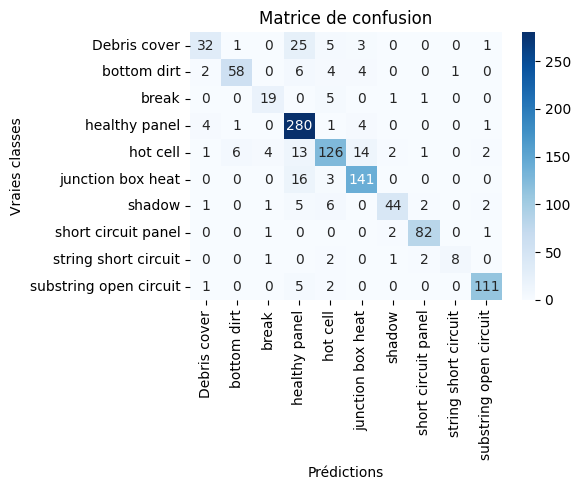

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.78      0.48      0.59        67
           bottom dirt       0.88      0.77      0.82        75
                 break       0.73      0.73      0.73        26
         healthy panel       0.80      0.96      0.87       291
              hot cell       0.82      0.75      0.78       169
     junction box heat       0.85      0.88      0.87       160
                shadow       0.88      0.72      0.79        61
   short circuit panel       0.93      0.95      0.94        86
  string short circuit       0.89      0.57      0.70        14
substring open circuit       0.94      0.93      0.94       119

              accuracy                           0.84      1068
             macro avg       0.85      0.77      0.80      1068
          weighted avg       0.84      0.84      0.84      1068



In [67]:
best_pipelines_results_80_20 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_80_20, split_name="80.20")

In [68]:
best_pipelines_results_80_20 = best_pipelines_results_80_20.sort_values("test_f1_macro", ascending=False)
display(best_pipelines_results_80_20)

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_preproc_time,train_fit_time,total_train_time,predict_preproc_time,predict_pred_time,total_pred_time,n_features_pre_selector,n_features_post_selector
CatBoost,80.20,0.843633,0.803259,0.838497,0.774973,0.843633,0.849901,0.844925,95.820275,33.197500,129.017776,23.191518,0.004451,23.195968,49.0,39.0
XGBoost,80.20,0.826779,0.795259,0.820579,0.769130,0.826779,0.842420,0.830123,109.921954,1.591777,111.513731,29.558152,0.008884,29.567037,76.0,76.0
LightGBM,80.20,0.838015,0.794433,0.832293,0.767709,0.838015,0.840439,0.842878,114.830024,5.257593,120.087617,29.496306,0.027549,29.523855,76.0,76.0
SVC,80.20,0.813670,0.776733,0.818076,0.789183,0.813670,0.773324,0.830083,115.549904,0.327238,115.877141,27.702787,0.183627,27.886414,76.0,60.0
RandomForest,80.20,0.816479,0.776703,0.810963,0.746665,0.816479,0.824611,0.816289,91.877902,2.071206,93.949107,25.465741,0.015024,25.480765,60.0,60.0
DecisionTree,80.20,0.724719,0.644257,0.719032,0.627418,0.724719,0.669948,0.721138,99.371788,0.181774,99.553561,22.865702,0.000000,22.865702,49.0,49.0


In [69]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
    "test_f1_macro": "F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
}

display_best_pipelines_graphs(best_pipelines_results_80_20)


# Meilleur pipeline & meilleur classifieur

Sur notre split de travail 80/20, les résultats obtenus à l'aide de ce notebook montrent que le pipeline présentant le meilleur compromis entre les performances et le temps d'aprentissage est basé sur **XGBoost**, avec les caractéristiques suivantes :

- Augmentation de données : **Non**
- Features :
  - Indicateurs statistiques de base : **Oui**
  - Densité de contours : **Oui**
  - Carte d'entropie : **Oui**
  - Caractéristiques GLCM : **Oui**
  - Histogramme : **Non**
  - Détection HotSpots : **Non**
- Scaling : **Non**
- Sélection de features ou réduction de dimension : **Non**
- Classifieur : **XGBoost**

Avec ces paramètres, XGBoost donne les résultats suivants :
- **Accuracy** : **82,7%**
- **f1_score_macro** : **79,5%**

Cela dit, les résultats obtenus avec les classifieurs suivants sont très proches de ceux obtenus avec ce pipeline :
- **LightGBM** - Le meilleur pipeline basé sur LGBM est même meilleur en accuracy (83,8%), mais il est un peu plus long en termes de temps d'apprentissage.
- **CatBoost** - Le meilleur pipeline basé sur CatBoost est meilleur en accuracy (83,6%) et présente un f1_score similaire, mais son temps d'entraînement est rédhibitoire. De plus nous avons noté, au cours des différentes exécutions de ce notebook, que malgré l'utilisation du paramètre `random_seed`, les scores de CatBoost varient légèrement et ne sont pas rigoureusement reproductibles.

## Résultats sur le jeu train/test de référence

Afin de comparer les résultats entre les différentes approches et modèles évalués au sein de notre groupe projet, nous avons choisi comme référence de comparaison le split train/test 90/10 tel que défini par les auteurs du dataset. \
Ce split intègre les images 110x60 étiquetées "Doute_Carré".

In [70]:
# On recharge le dataset pour récupérer les images qu'on avait initialement écartées pour "Doute_Carre"
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=False)

# Ensuite on extrait les jeux d'entraînement et de test
df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
X_train = df_train.drop('Classe', axis=1)
y_train = df_train['Classe']
X_test = df_test.drop('Classe', axis=1)
y_test = df_test['Classe']

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 5019
Nb d'images dans l'ensemble de test : 553



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur RandomForest pour le split 90.10
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 110.72 secondes
Entraînement - Temps de fit: 2.07 secondes
Temps total d'entraînement (pre-processing + fit): 112.79 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots',
                                                 HotSpotsExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', MinMaxScaler()),
                ('selector', 'passthrough'),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=17,
                                        min_samples_leaf=2, n_estimators=95,
                                        random_state=42))])

Prédiction - Temps de pre-processing: 12.36 secondes
Prédiction - Temps de prédiction: 0.01 secondes
Temps total de prédiction (pre-processing + prediction): 12.37 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


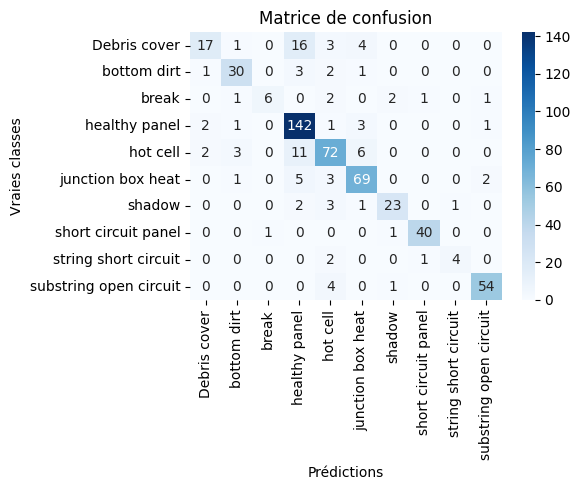

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.77      0.41      0.54        41
           bottom dirt       0.81      0.81      0.81        37
                 break       0.86      0.46      0.60        13
         healthy panel       0.79      0.95      0.86       150
              hot cell       0.78      0.77      0.77        94
     junction box heat       0.82      0.86      0.84        80
                shadow       0.85      0.77      0.81        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       0.93      0.92      0.92        59

              accuracy                           0.83       553
             macro avg       0.84      0.75      0.78       553
          weighted avg       0.83      0.83      0.82       553


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', RobustScaler()),
                ('selector', 'passthrough'),
                ('model',
                 DecisionTreeClassifier(max_depth=12, random_state=32))])

Prédiction - Temps de pre-processing: 12.39 secondes
Prédiction - Temps de prédiction: 0.00 secondes
Temps total de prédiction (pre-processing + prediction): 12.39 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


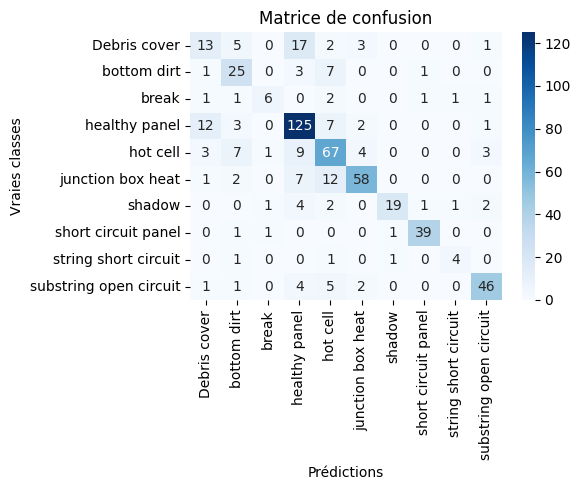

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.41      0.32      0.36        41
           bottom dirt       0.54      0.68      0.60        37
                 break       0.67      0.46      0.55        13
         healthy panel       0.74      0.83      0.78       150
              hot cell       0.64      0.71      0.67        94
     junction box heat       0.84      0.72      0.78        80
                shadow       0.90      0.63      0.75        30
   short circuit panel       0.93      0.93      0.93        42
  string short circuit       0.67      0.57      0.62         7
substring open circuit       0.85      0.78      0.81        59

              accuracy                           0.73       553
             macro avg       0.72      0.66      0.68       553
          weighted avg       0.73      0.73      0.72       553


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 XG...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 14.45 secondes
Prédiction - Temps de prédiction: 0.01 secondes
Temps total de prédiction (pre-processing + prediction): 14.46 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


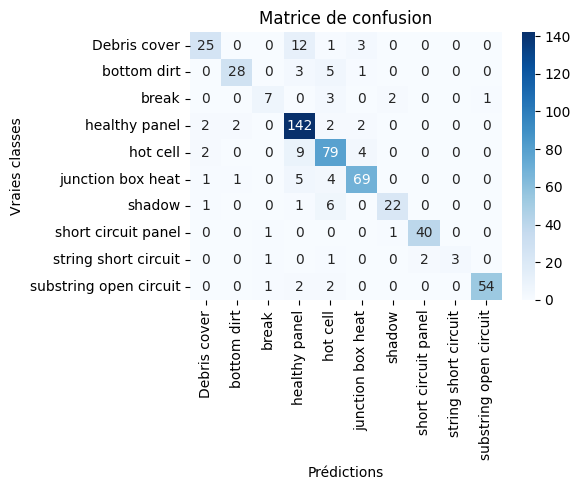

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.81      0.61      0.69        41
           bottom dirt       0.90      0.76      0.82        37
                 break       0.70      0.54      0.61        13
         healthy panel       0.82      0.95      0.88       150
              hot cell       0.77      0.84      0.80        94
     junction box heat       0.87      0.86      0.87        80
                shadow       0.88      0.73      0.80        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      0.92      0.95        59

              accuracy                           0.85       553
             macro avg       0.87      0.76      0.80       553
          weighted avg       0.85      0.85      0.84       553


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x00000153788884A0>)),
                ('model', SVC(C=10, class_weight='balanced'))])

Prédiction - Temps de pre-processing: 14.07 secondes
Prédiction - Temps de prédiction: 0.32 secondes
Temps total de prédiction (pre-processing + prediction): 14.39 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


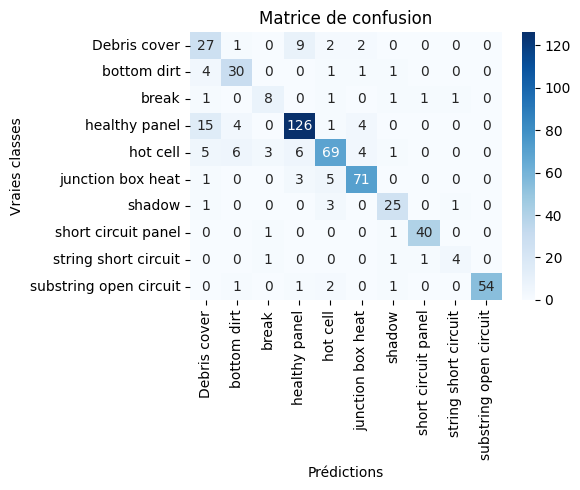

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.50      0.66      0.57        41
           bottom dirt       0.71      0.81      0.76        37
                 break       0.62      0.62      0.62        13
         healthy panel       0.87      0.84      0.85       150
              hot cell       0.82      0.73      0.78        94
     junction box heat       0.87      0.89      0.88        80
                shadow       0.81      0.83      0.82        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       0.67      0.57      0.62         7
substring open circuit       1.00      0.92      0.96        59

              accuracy                           0.82       553
             macro avg       0.78      0.78      0.78       553
          weighted avg       0.83      0.82      0.82       553


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20,
                                num_leaves=127, objective='multiclass'))])

Prédiction - Temps de pre-processing: 14.21 secondes
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Prédiction - Temps de prédiction: 0.01 secondes
Temps total de prédiction (pre-processing + prediction): 14.22 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


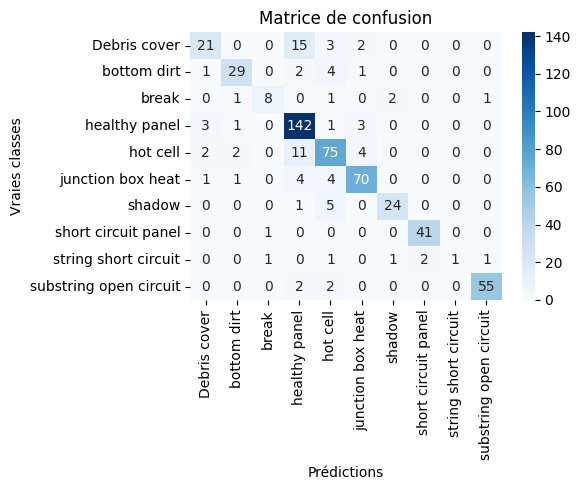

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.75      0.51      0.61        41
           bottom dirt       0.85      0.78      0.82        37
                 break       0.80      0.62      0.70        13
         healthy panel       0.80      0.95      0.87       150
              hot cell       0.78      0.80      0.79        94
     junction box heat       0.88      0.88      0.88        80
                shadow       0.89      0.80      0.84        30
   short circuit panel       0.95      0.98      0.96        42
  string short circuit       1.00      0.14      0.25         7
substring open circuit       0.96      0.93      0.95        59

              accuracy                           0.84       553
             macro avg       0.87      0.74      0.77       553
          weighted avg       0.84      0.84      0.84       553


-----------------------------------------------------------------------

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x00000153788884A0>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000153BB78DF10>)])

Prédiction - Temps de pre-processing: 11.89 secondes
Prédiction - Temps de prédiction: 0.00 secondes
Temps total de prédiction (pre-processing + prediction): 11.90 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


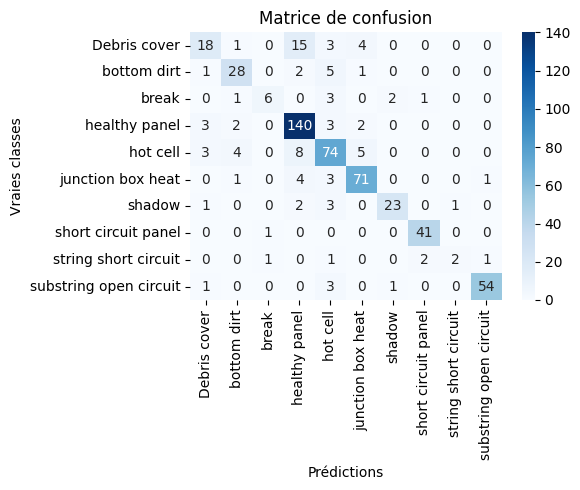

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.67      0.44      0.53        41
           bottom dirt       0.76      0.76      0.76        37
                 break       0.75      0.46      0.57        13
         healthy panel       0.82      0.93      0.87       150
              hot cell       0.76      0.79      0.77        94
     junction box heat       0.86      0.89      0.87        80
                shadow       0.88      0.77      0.82        30
   short circuit panel       0.93      0.98      0.95        42
  string short circuit       0.67      0.29      0.40         7
substring open circuit       0.96      0.92      0.94        59

              accuracy                           0.83       553
             macro avg       0.81      0.72      0.75       553
          weighted avg       0.82      0.83      0.82       553



In [71]:
best_pipelines_results_90_10 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_90_10, split_name="90.10")

In [72]:
best_pipelines_results_90_10 = best_pipelines_results_90_10.sort_values("test_f1_macro", ascending=False)
display(best_pipelines_results_90_10)

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_preproc_time,train_fit_time,total_train_time,predict_preproc_time,predict_pred_time,total_pred_time,n_features_pre_selector,n_features_post_selector
XGBoost,90.10,0.848101,0.797292,0.844949,0.758411,0.848101,0.868038,0.852252,131.405577,1.932980,133.338557,14.454129,0.005002,14.459131,76.0,76.0
SVC,90.10,0.820976,0.779255,0.824284,0.781867,0.820976,0.781142,0.831132,131.660636,0.377846,132.038482,14.067394,0.318084,14.385478,76.0,60.0
RandomForest,90.10,0.826401,0.777851,0.818879,0.746784,0.826401,0.837328,0.826736,110.724925,2.067067,112.791992,12.358750,0.008869,12.367620,60.0,60.0
LightGBM,90.10,0.842676,0.765931,0.835787,0.738215,0.842676,0.866874,0.844717,127.674475,3.931340,131.605815,14.208316,0.013515,14.221830,76.0,76.0
CatBoost,90.10,0.826401,0.748592,0.819214,0.720921,0.826401,0.805005,0.821949,110.237217,32.281788,142.519005,11.892863,0.003001,11.895864,49.0,39.0
DecisionTree,90.10,0.726944,0.684283,0.724796,0.663838,0.726944,0.718657,0.731780,111.528965,0.195853,111.724817,12.388210,0.000507,12.388717,49.0,49.0


In [73]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
    "test_f1_macro": "F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
}

display_best_pipelines_graphs(best_pipelines_results_90_10)

Sur ce split, XGBoost confirme ses bonnes performances et se retrouve même devant LightGBM et CatBoost.

On obtient les résultats suivants :
- **Accuracy** : **84,8%**
- **f1_score_macro** : **79,7%**

# Interprétabilité

Pour étudier l'interprétabilité, on réutilise notre split 80/20 de travail.

In [74]:
# Découpage train / test par défaut (split 80/20 de travail)
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=True)
splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 4270
Nb d'images dans l'ensemble de test : 1068


## XGBoost

On va étudier l'interprétabilité du pipeline basé sur XGBoost.

In [75]:
# On reprend notre pipeline avec les paramètres optimisés
xgboost_best_pipeline_params = deepcopy(best_pipelines["XGBoost"])
interp_pipeline = pipe.set_params(**xgboost_best_pipeline_params)

# Entraînement et prédiction
interp_pipeline.fit(X_train, y_train)
y_pred = interp_pipeline.predict(X_test)
y_pred_proba = interp_pipeline.predict_proba(X_test)

# On récupère l'ensemble train après l'extraction des features
start_pipe = interp_pipeline[1]
X_train_transformed = start_pipe.transform(X_train)
# display(X_train_transformed)

# On récupère l'ensemble test après l'extraction des features
X_test_transformed = start_pipe.transform(X_test)
# display(X_test_transformed)

# On récupère le classifieur XGBoost (étape finale de la pipeline)
xgbc = interp_pipeline[-1]


In [76]:
# On construit un dataframe sur la base du jeu de test, comprenant une colonne "classe réelle" et une colonne "classe prédite"
xgboost_best_pipeline_prediction_df = X_test[["Chemin", "Nom"]].reset_index(drop=True)

xgboost_best_pipeline_prediction_df["Classe réelle"] = xgboost_best_pipeline_prediction_df["Chemin"].apply(lambda x: PVModule.get_module(x).status)
xgboost_best_pipeline_prediction_df["Classe prédite"] = y_pred
xgboost_best_pipeline_prediction_df["Prédiction juste"] = xgboost_best_pipeline_prediction_df["Classe réelle"] == xgboost_best_pipeline_prediction_df["Classe prédite"]

# On ajoute les probabilités calculées pour chaque classe possible
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=xgbc.classes_)
xgboost_best_pipeline_prediction_df = pd.concat([xgboost_best_pipeline_prediction_df, y_pred_proba_df], axis=1)

display(xgboost_best_pipeline_prediction_df)

,Chemin,Nom,Classe réelle,Classe prédite,Prédiction juste,Debris cover,bottom dirt,break,healthy panel,hot cell,junction box heat,shadow,short circuit panel,string short circuit,substring open circuit
0,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142942_0501_T_000012,short circuit panel,short circuit panel,True,0.000005,0.000020,0.000555,1.002210e-06,0.000008,9.820560e-07,0.000316,0.999001,0.000085,0.000009
1,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142942_0501_T_000006,short circuit panel,short circuit panel,True,0.000012,0.000011,0.000168,1.500450e-06,0.000007,2.683980e-06,0.000020,0.999710,0.000035,0.000033
2,../data/raw/PVF-10/PVF_10_110x60/train/05hot c...,DJI_20231116162835_0370_T_000001,hot cell,hot cell,True,0.095391,0.041818,0.001964,8.061124e-04,0.690074,5.614717e-03,0.153713,0.000747,0.006181,0.003692
3,../data/raw/PVF-10/PVF_10_110x60/train/03Debri...,DJI_20230223112115_0371_T_000004,Debris cover,healthy panel,False,0.053431,0.018107,0.000062,9.236959e-01,0.002899,1.015599e-03,0.000372,0.000087,0.000117,0.000213
4,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114120122_0420_T_000006,short circuit panel,short circuit panel,True,0.000003,0.000020,0.000137,1.536380e-06,0.000017,1.840781e-06,0.000746,0.998919,0.000132,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,DJI_20230317134304_0183_T_000001,healthy panel,healthy panel,True,0.000526,0.000011,0.000001,9.993880e-01,0.000009,4.171627e-05,0.000009,0.000002,0.000003,0.000010
1064,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142950_0505_T_000009,short circuit panel,short circuit panel,True,0.000014,0.000003,0.000018,5.968936e-07,0.000013,2.064038e-06,0.000050,0.999791,0.000105,0.000004
1065,../data/raw/PVF-10/PVF_10_110x60/train/03Debri...,DJI_20230513154313_0632_T_000003,Debris cover,Debris cover,True,0.996467,0.000352,0.000011,2.594331e-03,0.000331,1.403883e-04,0.000034,0.000015,0.000022,0.000033
1066,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,DJI_20230308152902_0381_T_000014,healthy panel,healthy panel,True,0.002702,0.004392,0.000040,9.919825e-01,0.000576,4.406826e-05,0.000172,0.000036,0.000029,0.000026


### Interprétabilité spécifique

Le classifieur **XGBoost** permet une **interprétabilité spécifique**. Afin de mieux comprendre l'**importance des features**, nous pouvons les regrouper par catégorie :
- **stats** : indicateurs statistiques "basiques"
- **stats__p_** : les 19 percentiles, de 5% à 95% par pas de 5%
- **glcm__*propriété*** : les 5 propriétés GLCM **contrast**, **dissimilarity**, **homogeneity**, **energy** & **correlation**
- **edgedensity** : la densité de contours
- **entropy** : les indicateurs statistiques de la carte d'entropie
- **entropy__hist** : l'histogramme des valeurs d'entropie

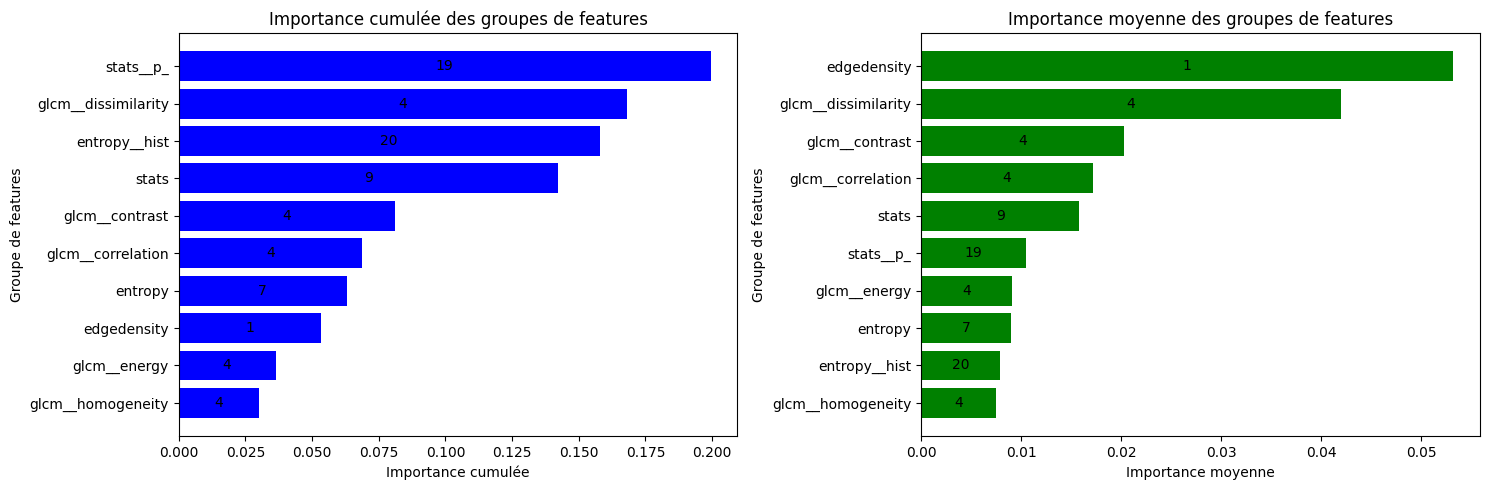

In [77]:
# Récupération de l'importance des features utilisées par notre classifieur
importances = xgbc.feature_importances_

# Regroupement des features par catégorie 
feature_groups = X_test_transformed.columns.str.extract(
        r'^(stats__p_|stats|glcm__contrast|glcm__dissimilarity|glcm__homogeneity|glcm__energy|glcm__correlation|edgedensity|entropy__hist|entropy)',
        expand=False)
importances_df = pd.DataFrame({
    "feature": X_test_transformed.columns,
    "importance": importances,
    "groupe": feature_groups
})

# Importance cumulée par catégorie
group_importance = importances_df.groupby("groupe")["importance"].agg({"sum", "count"}).sort_values("sum")

# Importance moyenne par catégorie
group_mean = importances_df.groupby("groupe")["importance"].agg({"mean", "count"}).sort_values("mean")

# Affichage sur 2 graphes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,5))

p = axs[0].barh(group_importance.index, group_importance["sum"], color="blue")
axs[0].bar_label(p, labels=group_importance["count"], label_type='center')
axs[0].set_title("Importance cumulée des groupes de features")
axs[0].set_xlabel("Importance cumulée")
axs[0].set_ylabel("Groupe de features")

p = axs[1].barh(group_mean.index, group_mean["mean"], color="green")
axs[1].bar_label(p, labels=group_mean["count"], label_type='center')
axs[1].set_title("Importance moyenne des groupes de features")
axs[1].set_xlabel("Importance moyenne")
axs[1].set_ylabel("Groupe de features")

plt.tight_layout()
plt.show()

**Constatations** :
- Le feature **EdgeDensity** pèse à lui seul (sur 76 features utilisés) pour plus de 5% dans les prédictions du classifieur
- Le groupe des **19 percentiles** (**stats__p_**) pèse pour environ 20% dans les prédictions
- Les 5 propriétés **GLCM** pèsent, en cumulé, pour plus de 35% dans les prédictions, les 4 valeurs de la propriété **Dissimilarity** étant les plus importantes
- Les 20 valeurs de l'histogramme de la carte d'**Entropy** (**entropy__hist**) apparaissent aussi particulièrement utiles
- Enfin, les 9 **Indicateurs statistiques de base** (**stats**) pèsent pour environ 14% dans les prédictions

Nous pouvons aussi inspecter les importances individuelles, par groupe de features.

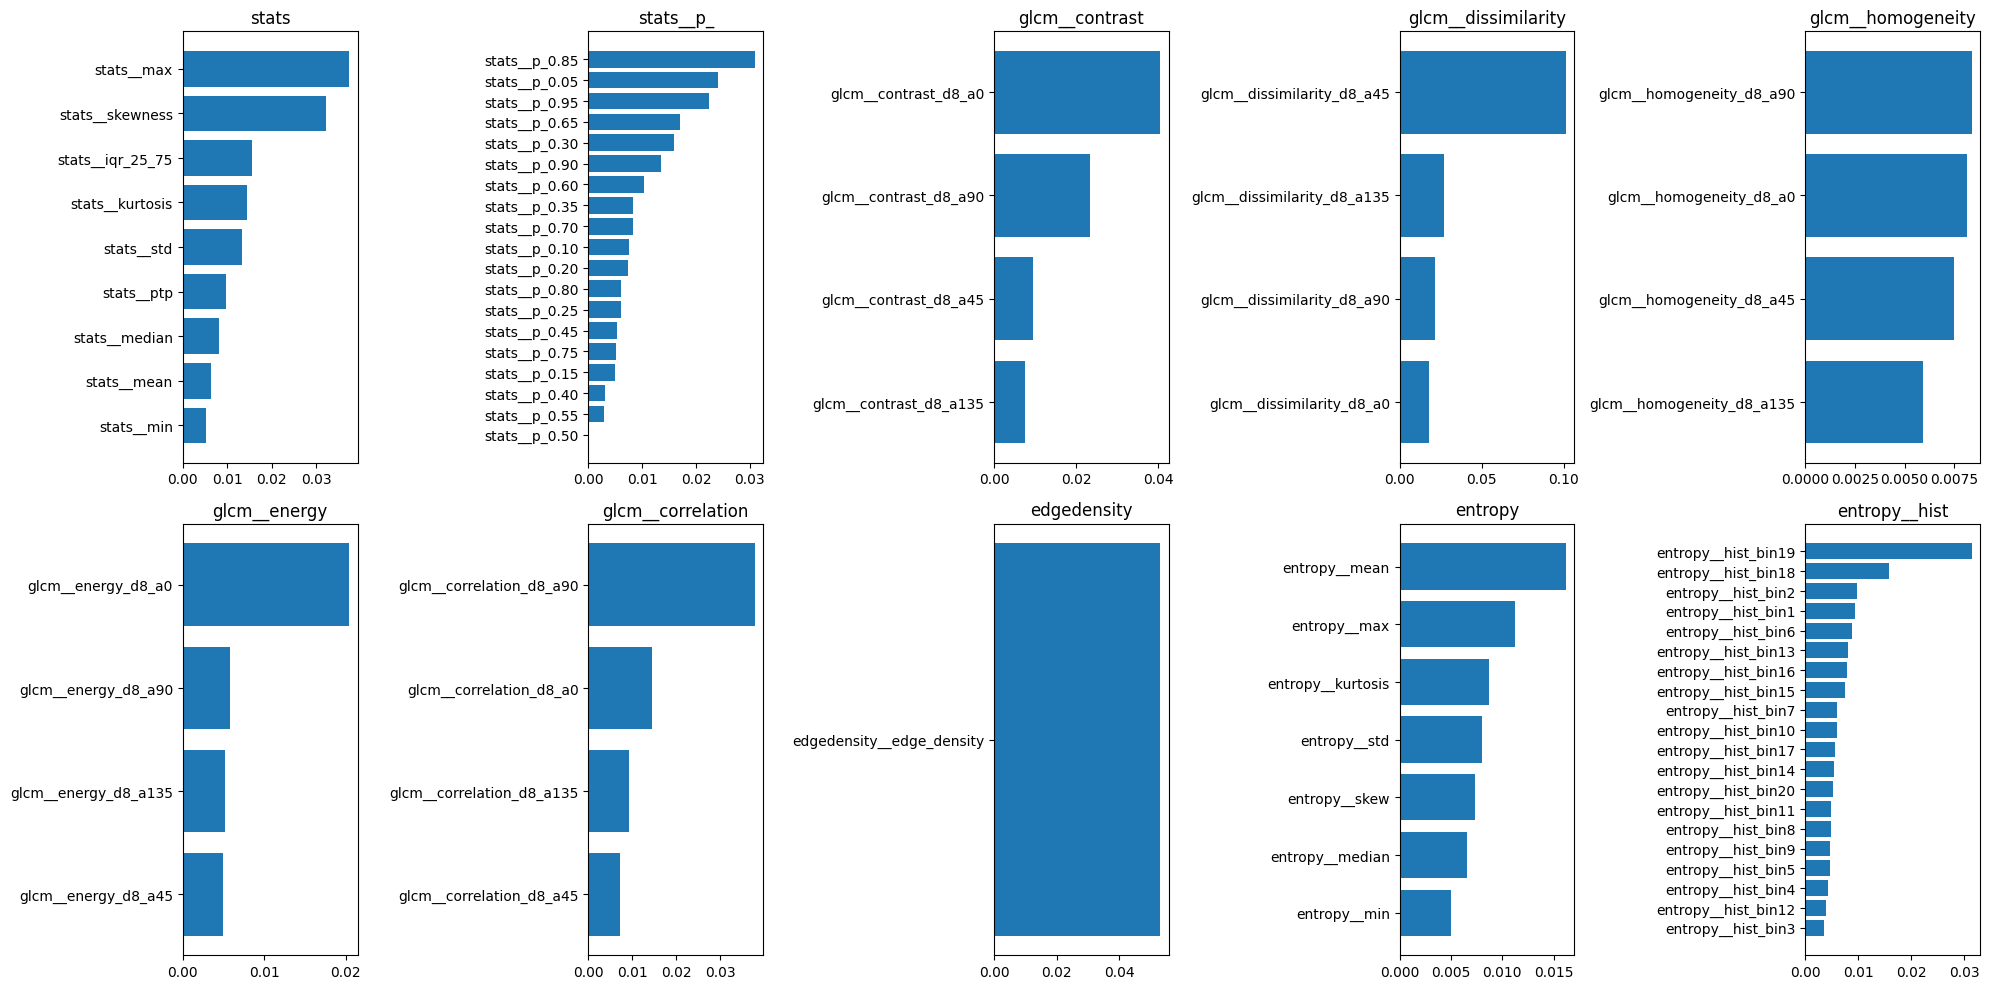

In [78]:
# Initialisation de la figure
fig,axes = plt.subplots(2, 5, figsize=(20,10))

# Pour chaque groupe de features
for i, group in enumerate(importances_df['groupe'].unique()):
    
    # Création du barplot

    current_importances_df = importances_df[importances_df["groupe"] == group].sort_values("importance")

    plt.subplot(2, 5, i+1)
    plt.barh(current_importances_df["feature"], current_importances_df["importance"])
    plt.title(group)

plt.tight_layout()
plt.show()

**Constatations** :

**Indicateurs statistiques** :
- La valeur **max** des pixels de l'image et la **skewness** (coefficient d'asymétrie) sont les features les plus influents.

**Percentiles** :
- Les percentiles extrèmes (85 et 95, 90 n'est pas très loin; ainsi que 05) apparaissent les plus influents.

**Propriétés GLCM** 
- A part pour la propriété **dissimilarity**, les directions 0 (verticale) et 90 (horizontale) fournissent les features les plus influents. Cela semble assez logique car les cellules dans les modules photovoltaïques sont disposées en "damier". Les différences de température entre une cellule défectueuse et ses voisines saines seront plus significatives dans ces directions.

**Entropy** :
- La moyenne (**mean**) de la carte d'entropie est la caractéristique la plus influente.
- Parmi les valeurs de l'**histogramme** de la carte d'entropie, les extrèmes sont les plus influents.

### Interprétabilité SHAP globale

Nous allons maintenant utiliser le modèle d'interprétabilité **SHAP Tree Explainer** qui est adapté à un classifieur basé sur XGBoost. On commence par l'interprétabilité globale sur l'ensemble des classes.

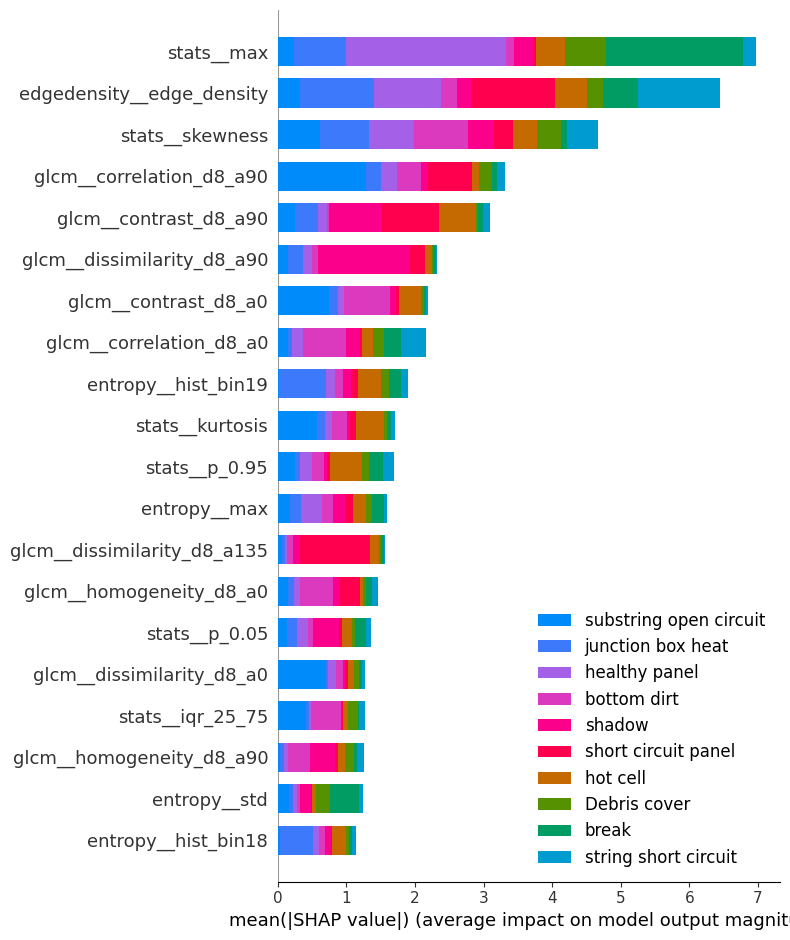

In [79]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer
import shap

# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(xgbc.clf)

# Calculer les shap-values pour le jeu de test (après extraction des features)
shap_values = explainer.shap_values(X_test_transformed)

# Afficher l'interprétation globale
shap.summary_plot(shap_values, X_test_transformed, plot_type='bar', class_names=xgbc.classes_)

**Constatations** :

SHAP confirme l'importance des features suivants :
- **stats__max** : la valeur max des pixels de l'image. Notamment pour les classes **healthy** et **break**
- **edge_density** : en particulier pour les classes **junction box**, **healthy**, **short circuit panel** et **string short circuit**
- **stats__skewness** : de façon plutôt équilibrée pour l'ensemble des classes
- les propriétés **GLCM** en général

### Interprétabilité SHAP locale

**On commence par interpréter une image sur laquelle le modèle a vu juste**

Réel : healthy panel
Prédit : healthy panel


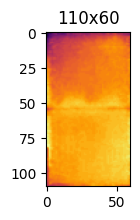

In [80]:
# On choisit une instance de test à expliquer
idx = 5
module = PVModule.get_module(xgboost_best_pipeline_prediction_df.loc[idx]["Chemin"])

actual_class = xgboost_best_pipeline_prediction_df.loc[idx, "Classe réelle"]
predicted_class = xgboost_best_pipeline_prediction_df.loc[idx, "Classe prédite"]

print(f"Réel : {actual_class}")
print(f"Prédit : {predicted_class}")
module.plot(display_colorbar=False)

In [81]:
print (f"Probabilité prédiction classe '{actual_class}' : {xgboost_best_pipeline_prediction_df.loc[idx, predicted_class]}")

Probabilité prédiction classe 'healthy panel' : 0.9953539371490479


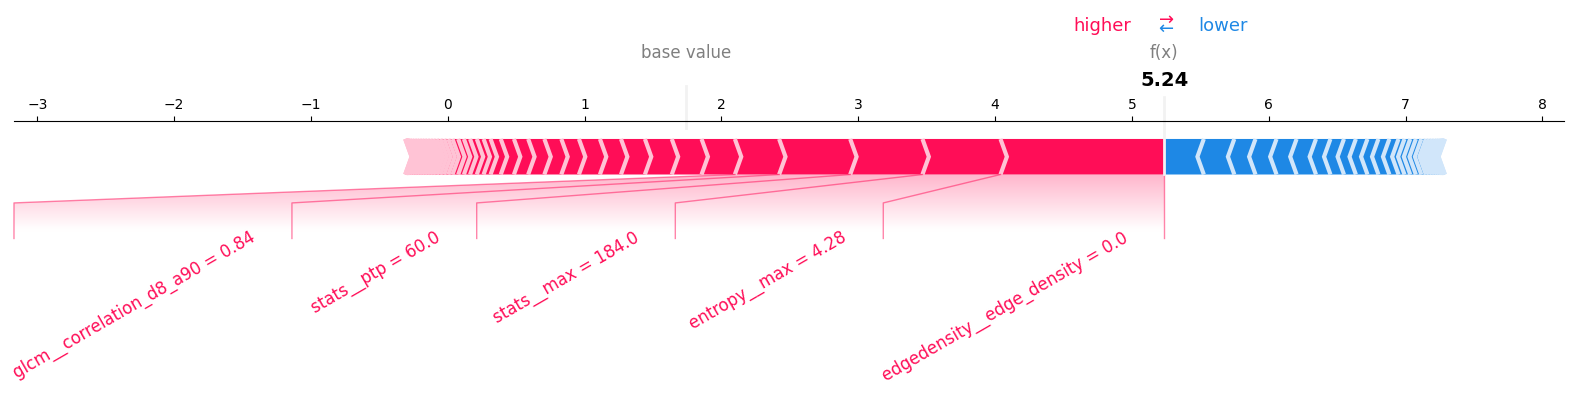

In [82]:
# Force-plot SHAP sur la classe prédite
predicted_class_idx = xgbc.classes_.tolist().index(predicted_class)
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)

Pour bien comprendre comment se situent les valeurs des features les plus importants par rapport à leur distribution au sein de l'ensemble des échantillons de test, on affiche leurs histogrammes respectifs.

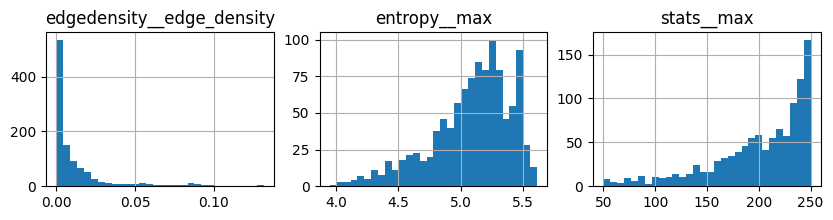

In [83]:
plt.figure(figsize=(10, 2))
for i, feature_name in enumerate(["edgedensity__edge_density", "entropy__max", "stats__max"]):
    plt.subplot(1, 3, i+1)
    X_test_transformed[feature_name].hist(bins=30)
    plt.title(f"{feature_name}")
plt.show()

**Explications** :

On constate que les features les plus influents sur le classement de ce module en **healthy** sont les suivants :
- Valeur nulle de l'**edge_density** (densité de contours) : facteur principal
- Faible **valeur max de l'entropie** (4.28)
- **Valeur max** des pixels de l'image (184), plutôt médiane

**On observe maintenant une image sur laquelle le modèle s'est trompé**

Réel : Debris cover
Prédit : healthy panel


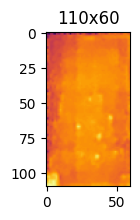

In [84]:
# On choisit une instance de test à expliquer
idx = 3
module = PVModule.get_module(xgboost_best_pipeline_prediction_df.loc[idx]["Chemin"])

actual_class = xgboost_best_pipeline_prediction_df.loc[idx, "Classe réelle"]
predicted_class = xgboost_best_pipeline_prediction_df.loc[idx, "Classe prédite"]

print(f"Réel : {actual_class}")
print(f"Prédit : {predicted_class}")
module.plot(display_colorbar=False)

In [85]:
print (f"Probabilité prédiction classe '{actual_class}' (réel) : {xgboost_best_pipeline_prediction_df.loc[idx, actual_class]}")
print (f"Probabilité prédiction classe '{predicted_class}' : {xgboost_best_pipeline_prediction_df.loc[idx, predicted_class]}")

Probabilité prédiction classe 'Debris cover' (réel) : 0.05343112722039223
Probabilité prédiction classe 'healthy panel' : 0.9236959218978882


On va essayer de voir pourquoi on le modèle prédit la classe **healthy panel** plutôt que **Debris cover** sur cette image.

Importance des features pour la classe réelle (Debris cover) :


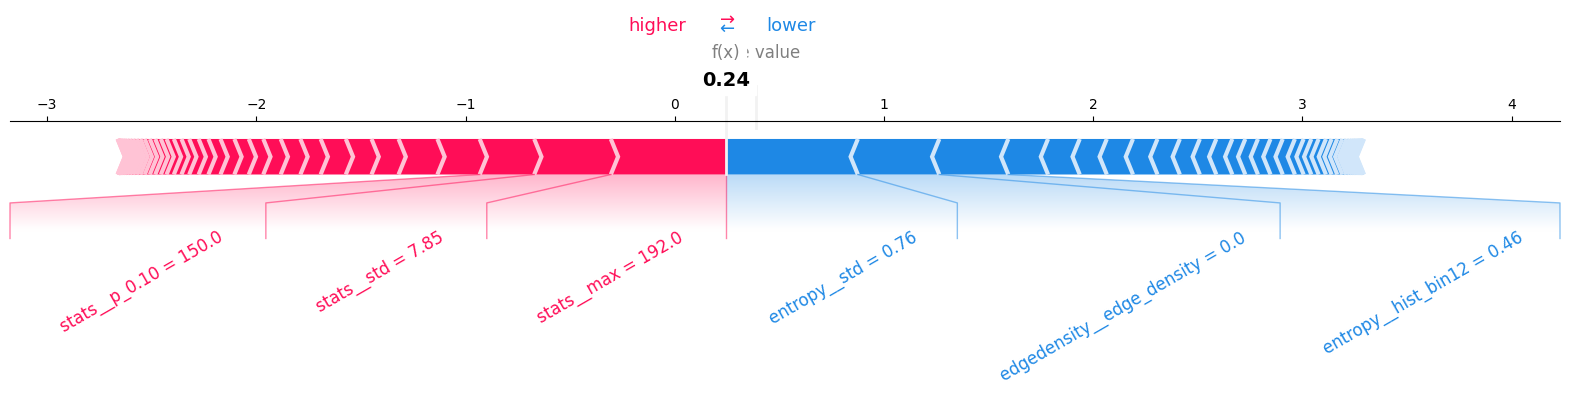

--------------------
Importance des features pour la classe prédite (healthy panel) :


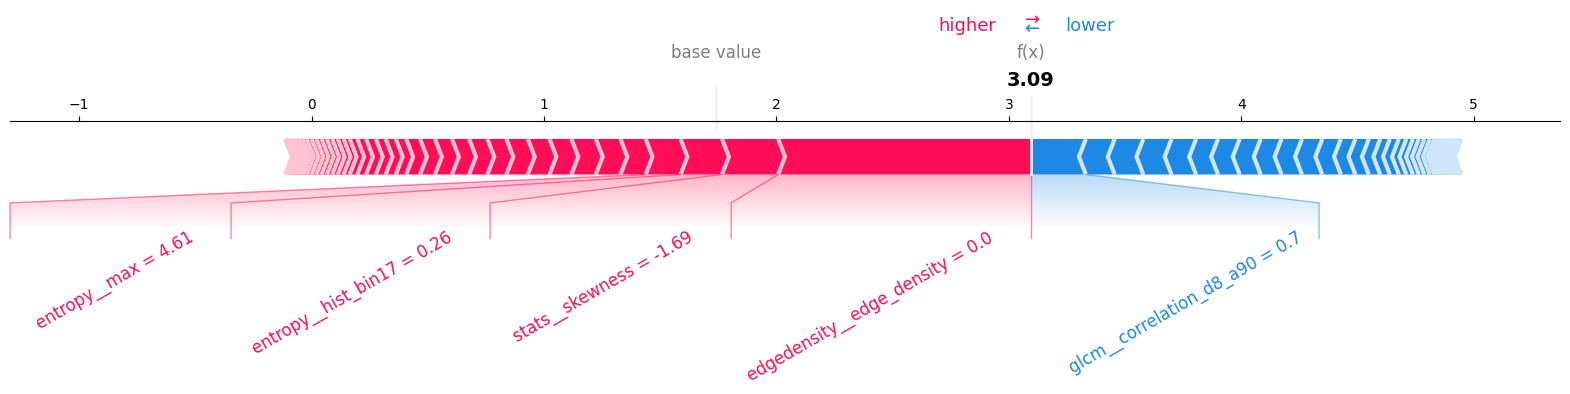

In [86]:
# Force-plot SHAP sur la classe réelle
actual_class_idx = xgbc.classes_.tolist().index(actual_class)
print (f"Importance des features pour la classe réelle ({actual_class}) :")
shap.force_plot(
    explainer.expected_value[actual_class_idx], 
    shap_values[idx,:,actual_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)
print ("-"*20)

# Force-plot SHAP sur la classe prédite
predicted_class_idx = xgbc.classes_.tolist().index(predicted_class)
print (f"Importance des features pour la classe prédite ({predicted_class}) :")
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.04, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)

**Explications** :

On peut noter en particulier que la valeur nulle d'**edge_density** influe à la fois dans le sens d'une augmentation de la probabilité de la classe **healthy** et d'une diminution de la probabilité de la classe réelle **debris cover**.

Une piste d'amélioration de l'extraction du feature "edge density" pourrait être de le rendre plus à même de détecter les contours des points chauds que l'on distingue visuellement sur l'image du module. 

## LightGBM

On va étudier l'interprétabilité du pipeline basé sur LightGBM.

In [ ]:
# On reprend notre pipeline avec les paramètres optimisés
lightbm_best_pipeline_params = deepcopy(best_pipelines["LightGBM"])
interp_pipeline = pipe.set_params(**lightbm_best_pipeline_params)

# Entraînement et prédiction
interp_pipeline.fit(X_train, y_train)
y_pred = interp_pipeline.predict(X_test)
y_pred_proba = interp_pipeline.predict_proba(X_test)

# On récupère l'ensemble train après l'extraction des features
start_pipe = interp_pipeline[1]
X_train_transformed = start_pipe.transform(X_train)
# display(X_train_transformed)

# On récupère l'ensemble test après l'extraction des features
X_test_transformed = start_pipe.transform(X_test)
# display(X_test_transformed)

# On récupère le classifieur LightGBM (étape finale de la pipeline)
lgbm = interp_pipeline[-1]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17576
[LightGBM] [Info] Number of data points in the train set: 4270, number of used features: 76
[LightGBM] [Info] Start training from score -2,768382
[LightGBM] [Info] Start training from score -2,648942
[LightGBM] [Info] Start training from score -3,714978
[LightGBM] [Info] Start training from score -1,298893
[LightGBM] [Info] Start training from score -1,843176
[LightGBM] [Info] Start training from score -1,897901
[LightGBM] [Info] Start training from score -2,870431
[LightGBM] [Info] Start training from score -2,527487
[LightGBM] [Info] Start training fr

In [92]:
# On construit un dataframe sur la base du jeu de test, comprenant une colonne "classe réelle" et une colonne "classe prédite"
lightbm_best_pipeline_prediction_df = X_test[["Chemin", "Nom"]].reset_index(drop=True)

lightbm_best_pipeline_prediction_df["Classe réelle"] = lightbm_best_pipeline_prediction_df["Chemin"].apply(lambda x: PVModule.get_module(x).status)
lightbm_best_pipeline_prediction_df["Classe prédite"] = y_pred
lightbm_best_pipeline_prediction_df["Prédiction juste"] = lightbm_best_pipeline_prediction_df["Classe réelle"] == lightbm_best_pipeline_prediction_df["Classe prédite"]

# On ajoute les probabilités calculées pour chaque classe possible
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=lgbm.classes_)
lightbm_best_pipeline_prediction_df = pd.concat([lightbm_best_pipeline_prediction_df, y_pred_proba_df], axis=1)

display(lightbm_best_pipeline_prediction_df)

,Chemin,Nom,Classe réelle,Classe prédite,Prédiction juste,Debris cover,bottom dirt,break,healthy panel,hot cell,junction box heat,shadow,short circuit panel,string short circuit,substring open circuit
0,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142942_0501_T_000012,short circuit panel,short circuit panel,True,6.648931e-08,6.896244e-08,1.879813e-06,8.572088e-08,8.559312e-08,5.932099e-08,1.802961e-06,9.999958e-01,1.065398e-07,6.643253e-08
1,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142942_0501_T_000006,short circuit panel,short circuit panel,True,4.817263e-08,4.733953e-08,4.837771e-07,5.928598e-08,8.850444e-08,3.218501e-08,3.277933e-08,9.999991e-01,3.639412e-08,1.199310e-07
2,../data/raw/PVF-10/PVF_10_110x60/train/05hot c...,DJI_20231116162835_0370_T_000001,hot cell,hot cell,True,2.392013e-01,9.334542e-02,5.094086e-04,1.381905e-03,5.001111e-01,2.216140e-03,1.611767e-01,3.284068e-04,5.145441e-04,1.215094e-03
3,../data/raw/PVF-10/PVF_10_110x60/train/03Debri...,DJI_20230223112115_0371_T_000004,Debris cover,healthy panel,False,2.937466e-02,5.521604e-03,1.905191e-05,9.630789e-01,4.057280e-04,1.373986e-03,7.399161e-05,4.380529e-05,2.695555e-05,8.133377e-05
4,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114120122_0420_T_000006,short circuit panel,short circuit panel,True,5.762047e-08,1.076819e-06,1.098045e-06,1.150333e-07,9.763304e-08,6.967693e-08,7.693674e-06,9.999895e-01,1.394047e-07,1.506250e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,DJI_20230317134304_0183_T_000001,healthy panel,healthy panel,True,1.431605e-05,5.343091e-08,2.609761e-08,9.999847e-01,9.987319e-08,6.040412e-07,5.301032e-08,4.175713e-08,2.746424e-08,1.153278e-07
1064,../data/raw/PVF-10/PVF_10_110x60/train/07short...,DJI_20231114142950_0505_T_000009,short circuit panel,short circuit panel,True,2.360412e-08,2.231362e-08,1.990506e-08,2.779016e-08,3.105718e-08,1.903021e-08,2.114190e-07,9.999995e-01,9.465801e-08,2.239839e-08
1065,../data/raw/PVF-10/PVF_10_110x60/train/03Debri...,DJI_20230513154313_0632_T_000003,Debris cover,Debris cover,True,9.999030e-01,3.464560e-06,1.000307e-07,5.623207e-05,3.415596e-05,2.021907e-06,2.935423e-07,2.111503e-07,1.581778e-07,3.496572e-07
1066,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,DJI_20230308152902_0381_T_000014,healthy panel,healthy panel,True,7.179650e-06,2.630412e-05,1.147235e-07,9.999544e-01,6.906157e-06,1.276609e-06,3.254654e-06,1.880067e-07,1.094751e-07,3.075357e-07


### Interprétabilité spécifique

Le classifieur **LightGBM** permet lui aussi une **interprétabilité spécifique**. Afin de mieux comprendre l'**importance des features**, nous pouvons les regrouper par catégorie :
- **stats** : indicateurs statistiques "basiques"
- **stats__p_** : les 19 percentiles, de 5% à 95% par pas de 5%
- **glcm__*propriété*** : les 5 propriétés GLCM **contrast**, **dissimilarity**, **homogeneity**, **energy** & **correlation**
- **edgedensity** : la densité de contours
- **entropy** : les indicateurs statistiques de la carte d'entropie
- **entropy__hist** : l'histogramme des valeurs d'entropie

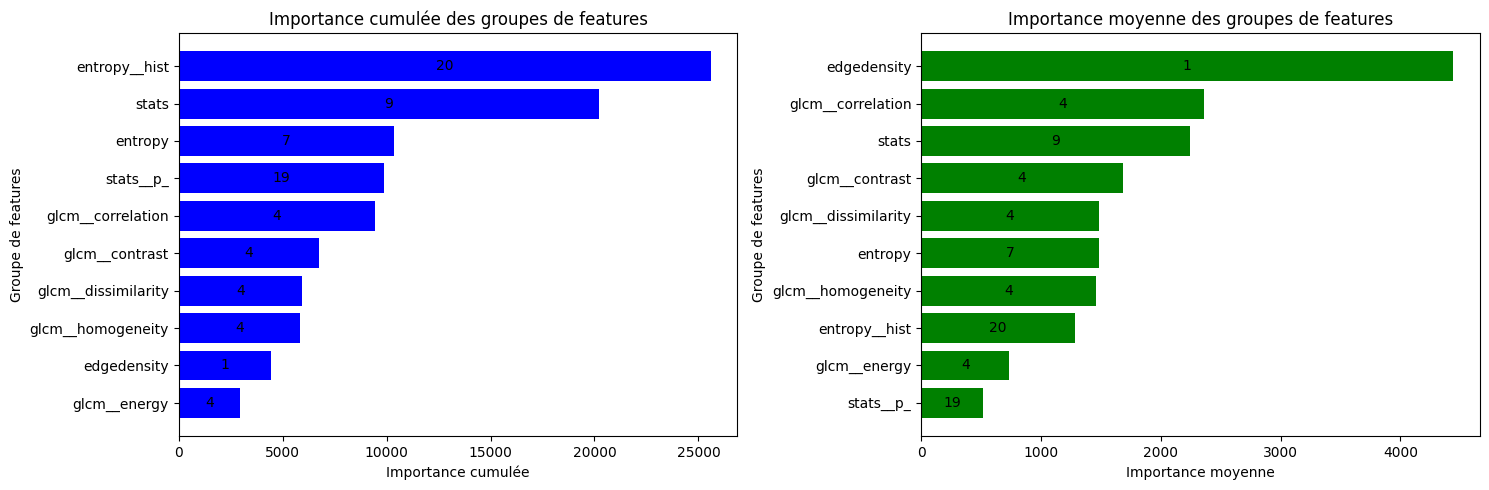

In [89]:
# Récupération de l'importance des features utilisées par notre classifieur
importances = lgbm.feature_importances_

# Regroupement des features par catégorie 
feature_groups = X_test_transformed.columns.str.extract(
        r'^(stats__p_|stats|glcm__contrast|glcm__dissimilarity|glcm__homogeneity|glcm__energy|glcm__correlation|edgedensity|entropy__hist|entropy)',
        expand=False)
importances_df = pd.DataFrame({
    "feature": X_test_transformed.columns,
    "importance": importances,
    "groupe": feature_groups
})

# Importance cumulée par catégorie
group_importance = importances_df.groupby("groupe")["importance"].agg({"sum", "count"}).sort_values("sum")

# Importance moyenne par catégorie
group_mean = importances_df.groupby("groupe")["importance"].agg({"mean", "count"}).sort_values("mean")

# Affichage sur 2 graphes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,5))

p = axs[0].barh(group_importance.index, group_importance["sum"], color="blue")
axs[0].bar_label(p, labels=group_importance["count"], label_type='center')
axs[0].set_title("Importance cumulée des groupes de features")
axs[0].set_xlabel("Importance cumulée")
axs[0].set_ylabel("Groupe de features")

p = axs[1].barh(group_mean.index, group_mean["mean"], color="green")
axs[1].bar_label(p, labels=group_mean["count"], label_type='center')
axs[1].set_title("Importance moyenne des groupes de features")
axs[1].set_xlabel("Importance moyenne")
axs[1].set_ylabel("Groupe de features")

plt.tight_layout()
plt.show()

**Constatations** :
- Le feature **EdgeDensity** pèse à lui seul (sur 76 features utilisés) pour plus de 5% dans les prédictions du classifieur
- Le groupe des **19 percentiles** (**stats__p_**) pèse pour environ 20% dans les prédictions
- Les 5 propriétés **GLCM** pèsent, en cumulé, pour plus de 35% dans les prédictions, les 4 valeurs de la propriété **Dissimilarity** étant les plus importantes
- Les 20 valeurs de l'histogramme de la carte d'**Entropy** (**entropy__hist**) apparaissent aussi particulièrement utiles
- Enfin, les 9 **Indicateurs statistiques de base** (**stats**) pèsent pour environ 14% dans les prédictions

Nous pouvons aussi inspecter les importances individuelles, par groupe de features.

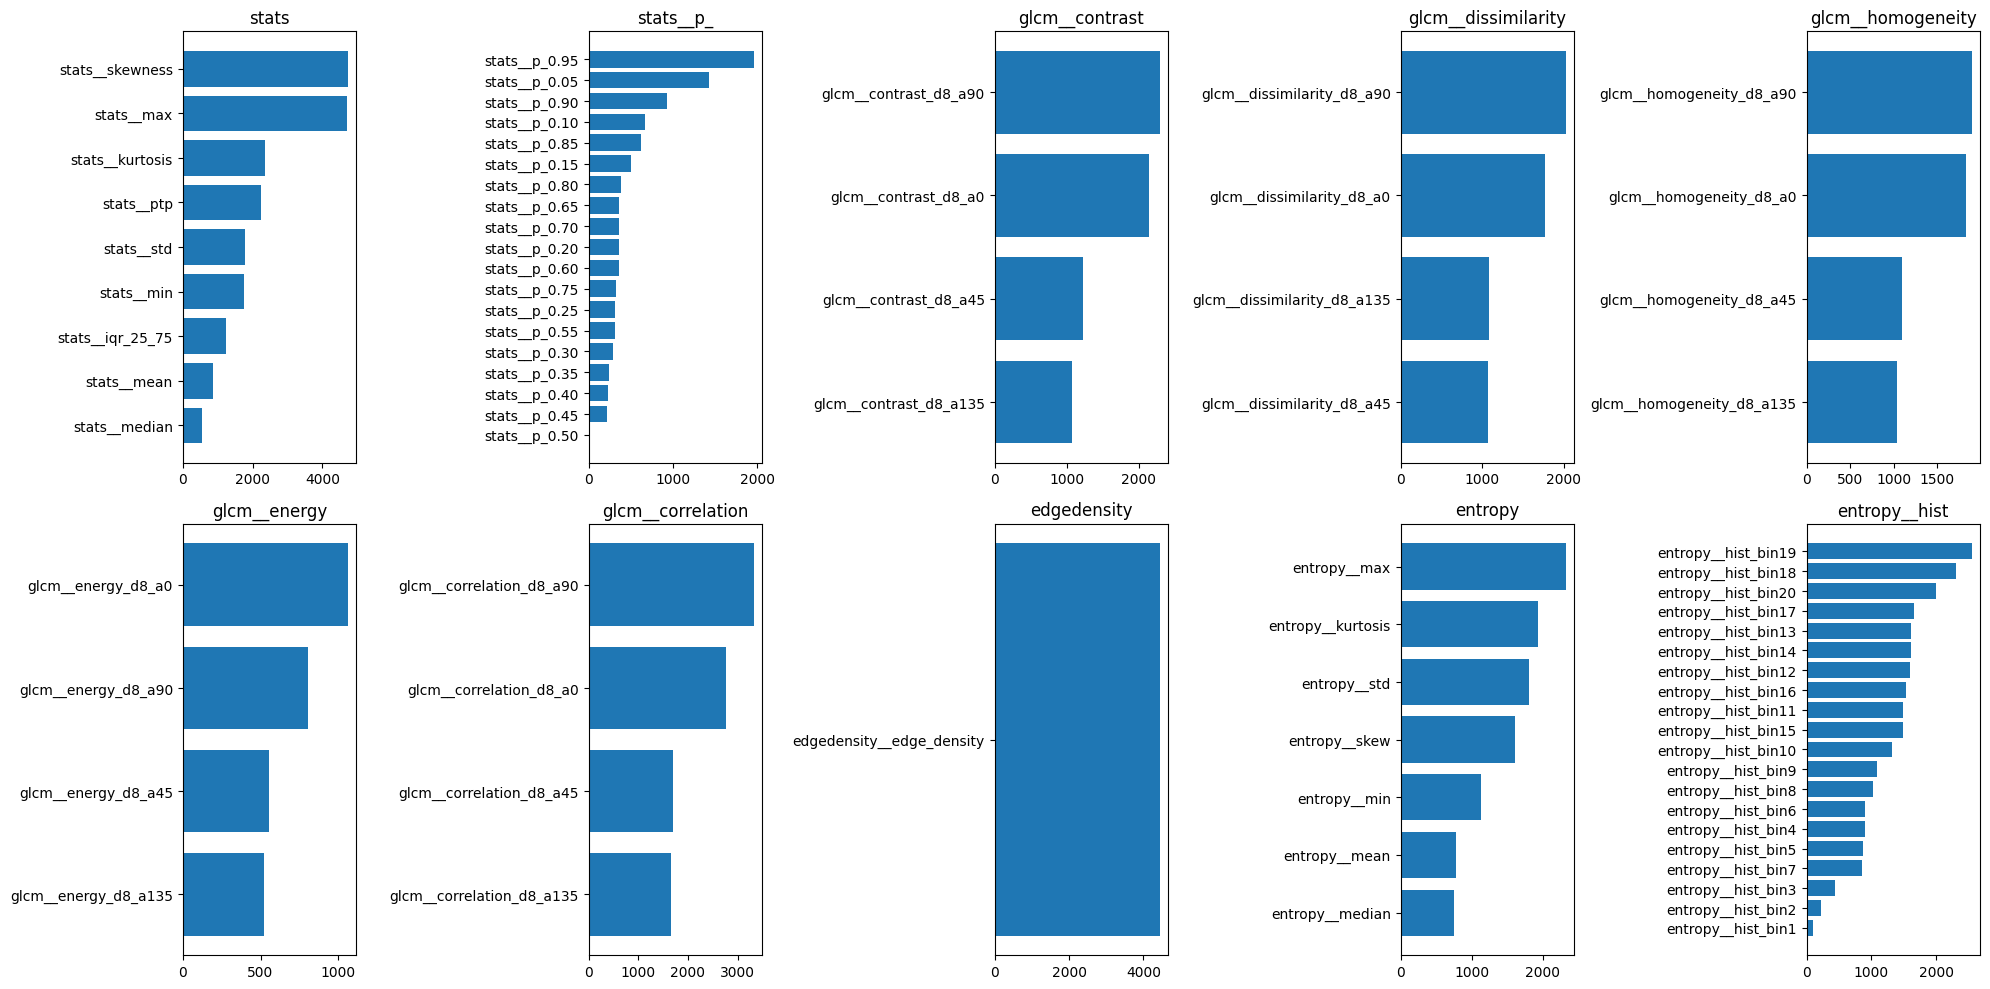

In [90]:
# Initialisation de la figure
fig,axes = plt.subplots(2, 5, figsize=(20,10))

# Pour chaque groupe de features
for i, group in enumerate(importances_df['groupe'].unique()):
    
    # Création du barplot

    current_importances_df = importances_df[importances_df["groupe"] == group].sort_values("importance")

    plt.subplot(2, 5, i+1)
    plt.barh(current_importances_df["feature"], current_importances_df["importance"])
    plt.title(group)

plt.tight_layout()
plt.show()

**Constatations** :

**Indicateurs statistiques** :
- La valeur **max** des pixels de l'image et la **skewness** (coefficient d'asymétrie) sont les features les plus influents.

**Percentiles** :
- Les percentiles extrèmes (85 et 95, 90 n'est pas très loin; ainsi que 05) apparaissent les plus influents.

**Propriétés GLCM** 
- A part pour la propriété **dissimilarity**, les directions 0 (verticale) et 90 (horizontale) fournissent les features les plus influents. Cela semble assez logique car les cellules dans les modules photovoltaïques sont disposées en "damier". Les différences de température entre une cellule défectueuse et ses voisines saines seront plus significatives dans ces directions.

**Entropy** :
- La moyenne (**mean**) de la carte d'entropie est la caractéristique la plus influente.
- Parmi les valeurs de l'**histogramme** de la carte d'entropie, les extrèmes sont les plus influents.

### Interprétabilité SHAP globale

Nous allons maintenant utiliser le modèle d'interprétabilité **SHAP Tree Explainer** qui est adapté à un classifieur basé sur XGBoost. On commence par l'interprétabilité globale sur l'ensemble des classes.

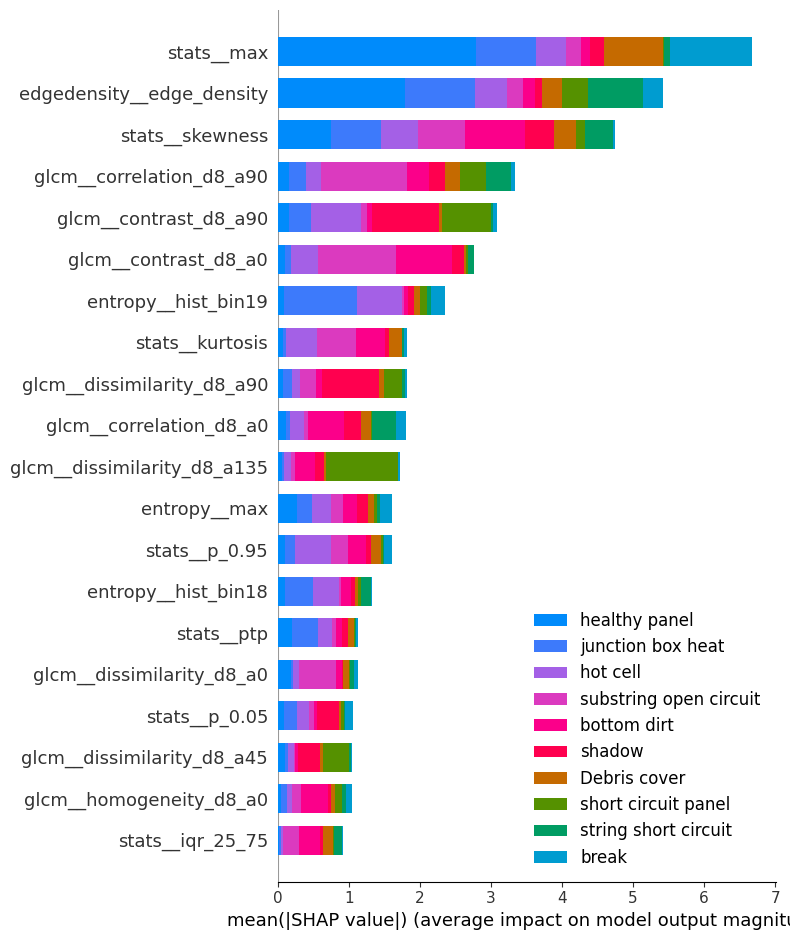

In [91]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer
import shap

# Créer un explainer SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(lgbm)

# Calculer les shap-values pour le jeu de test (après extraction des features)
shap_values = explainer.shap_values(X_test_transformed)

# Afficher l'interprétation globale
shap.summary_plot(shap_values, X_test_transformed, plot_type='bar', class_names=lgbm.classes_)

**Constatations** :

SHAP confirme l'importance des features suivants :
- **stats__max** : la valeur max des pixels de l'image. Notamment pour les classes **healthy** et **break**
- **edge_density** : en particulier pour les classes **healthy**, **junction box** et **string short circuit**
- **stats__skewness** : de façon plutôt équilibrée pour l'ensemble des classes
- les propriétés **GLCM** en général

### Interprétabilité SHAP locale

**On commence par interpréter une image sur laquelle le modèle a vu juste**

Réel : healthy panel
Prédit : healthy panel


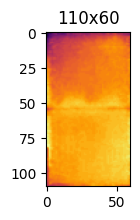

In [93]:
# On choisit une instance de test à expliquer
idx = 5
module = PVModule.get_module(lightbm_best_pipeline_prediction_df.loc[idx]["Chemin"])

actual_class = lightbm_best_pipeline_prediction_df.loc[idx, "Classe réelle"]
predicted_class = lightbm_best_pipeline_prediction_df.loc[idx, "Classe prédite"]

print(f"Réel : {actual_class}")
print(f"Prédit : {predicted_class}")
module.plot(display_colorbar=False)

In [94]:
print (f"Probabilité prédiction classe '{actual_class}' : {lightbm_best_pipeline_prediction_df.loc[idx, predicted_class]}")

Probabilité prédiction classe 'healthy panel' : 0.9999900634801814


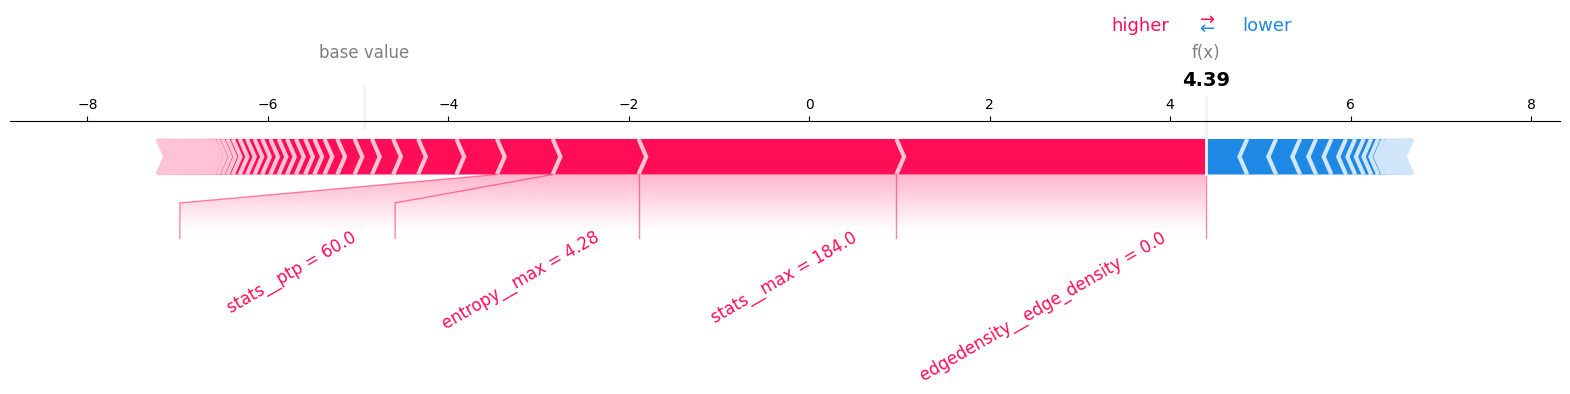

In [95]:
# Force-plot SHAP sur la classe prédite
predicted_class_idx = lgbm.classes_.tolist().index(predicted_class)
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)

Pour bien comprendre comment se situent les valeurs des features les plus importants par rapport à leur distribution au sein de l'ensemble des échantillons de test, on affiche leurs histogrammes respectifs.

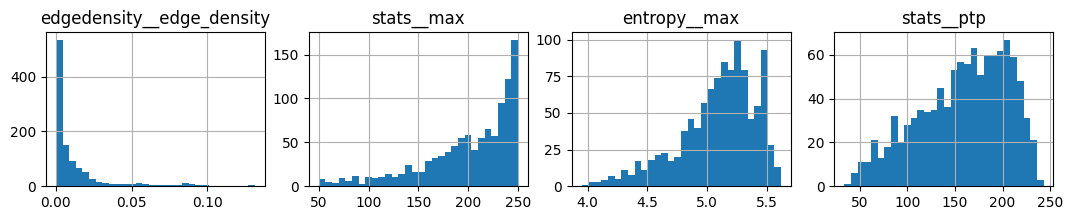

In [99]:
plt.figure(figsize=(13, 2))
for i, feature_name in enumerate(["edgedensity__edge_density", "stats__max", "entropy__max", "stats__ptp"]):
    plt.subplot(1, 4, i+1)
    X_test_transformed[feature_name].hist(bins=30)
    plt.title(f"{feature_name}")
plt.show()

**Explications** :

On constate que les features les plus influents sur le classement de ce module en **healthy** sont les suivants :
- Valeur nulle de l'**edge_density** (densité de contours) : facteur principal
- **Valeur max** des pixels de l'image (184), plutôt médiane
- Faible **valeur max de l'entropie** (4.28)
- Faible valeur de **stats__ptp** (60), qui représente l'écart min-max des valeurs des pixels de l'image

On notera que ce sont les 4 mêmes features (que pour **XGBoost**) qui influent le plus sur la classement de ce module en **healthy**.

**On observe maintenant une image sur laquelle le modèle s'est trompé**

Réel : Debris cover
Prédit : healthy panel


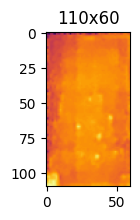

In [100]:
# On choisit une instance de test à expliquer
idx = 3
module = PVModule.get_module(lightbm_best_pipeline_prediction_df.loc[idx]["Chemin"])

actual_class = lightbm_best_pipeline_prediction_df.loc[idx, "Classe réelle"]
predicted_class = lightbm_best_pipeline_prediction_df.loc[idx, "Classe prédite"]

print(f"Réel : {actual_class}")
print(f"Prédit : {predicted_class}")
module.plot(display_colorbar=False)

In [101]:
print (f"Probabilité prédiction classe '{actual_class}' (réel) : {lightbm_best_pipeline_prediction_df.loc[idx, actual_class]}")
print (f"Probabilité prédiction classe '{predicted_class}' : {lightbm_best_pipeline_prediction_df.loc[idx, predicted_class]}")

Probabilité prédiction classe 'Debris cover' (réel) : 0.02937465508344769
Probabilité prédiction classe 'healthy panel' : 0.9630788890445418


On va essayer de voir pourquoi on le modèle prédit la classe **healthy panel** plutôt que **Debris cover** sur cette image.

Importance des features pour la classe réelle (Debris cover) :


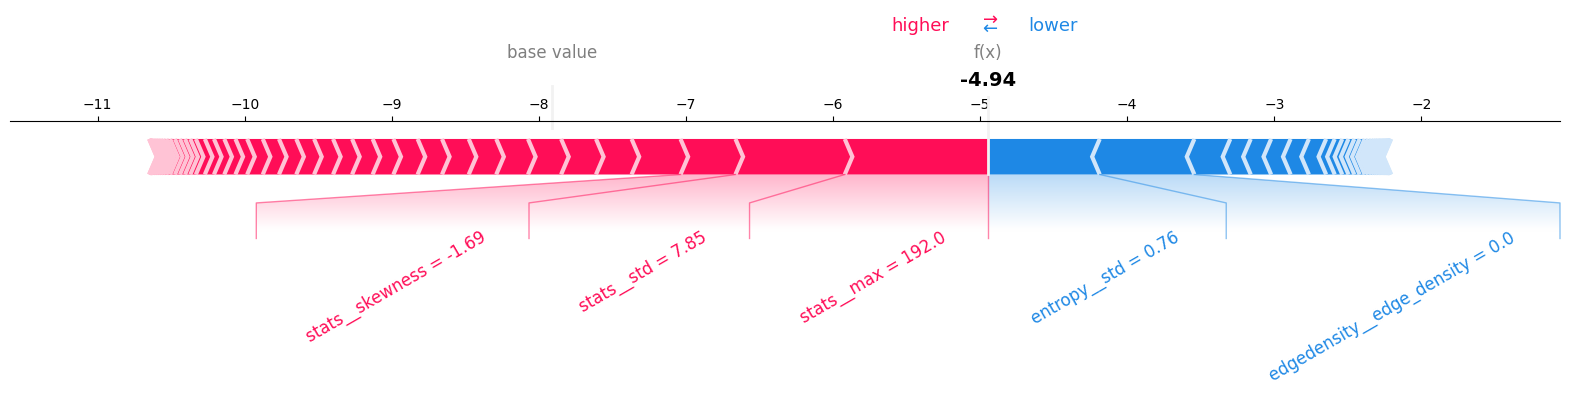

--------------------
Importance des features pour la classe prédite (healthy panel) :


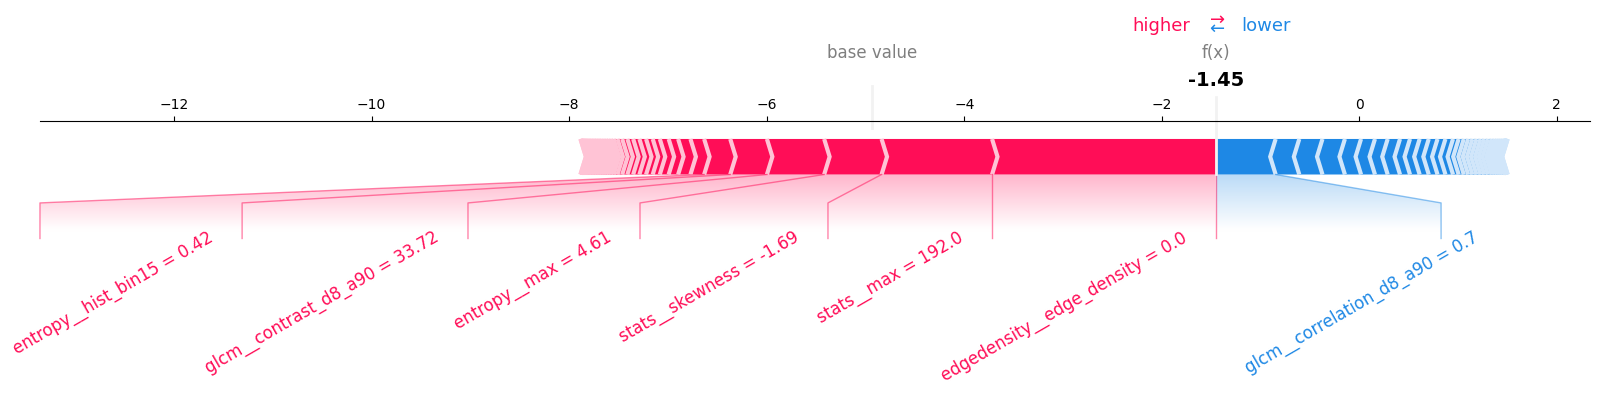

In [102]:
# Force-plot SHAP sur la classe réelle
actual_class_idx = lgbm.classes_.tolist().index(actual_class)
print (f"Importance des features pour la classe réelle ({actual_class}) :")
shap.force_plot(
    explainer.expected_value[actual_class_idx], 
    shap_values[idx,:,actual_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)
print ("-"*20)

# Force-plot SHAP sur la classe prédite
predicted_class_idx = lgbm.classes_.tolist().index(predicted_class)
print (f"Importance des features pour la classe prédite ({predicted_class}) :")
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.04, # On n'affiche que les features les + importants
    text_rotation=30,
    matplotlib=True,
)

**Explications** :

De la même façon que pour **XGBoost**, on peut noter que la valeur nulle d'**edge_density** influe à la fois dans le sens d'une augmentation de la probabilité de la classe **healthy** et d'une diminution de la probabilité de la classe réelle **debris cover**.


### Comparaison entre XGBoost et LightGBM

XGBoost et LightGBM étant basés tous les deux sur la construction séquentielle d'un ensemble d'arbres de décision à l'aide d'une descente de gradient, il est plutôt logique de retrouver de grandes similitudes dans leur façon d'exploiter les features disponibles.